In [1]:
import tracemalloc
import pickle
from cov_3X2 import *
from lsst_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
colors=sns.color_palette()


/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import lsst_utils
import cov_3X2
import tracer_utils
import window_utils
import importlib
reload=importlib.reload
reload(lsst_utils)
reload(window_utils)
reload(tracer_utils)
reload(cov_3X2)
from lsst_utils import *
from cov_3X2 import *

In [3]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
worker_kwargs={'memory_spill_fraction':.75,'memory_target_fraction':.99,'memory_pause_fraction':1}
LC=LocalCluster(n_workers=1,processes=False,memory_limit='60gb',threads_per_worker=10,
                local_dir='/home/deep/repos/cosmic_shear/temp/NGL-worker/',
               **worker_kwargs,
                #scheduler_port=12234,
#                 dashboard_address=8801
                diagnostics_port=8801,
#                memory_monitor_interval='2000ms')
               )
client=Client(LC,diagnostics_port=8801,)

#LC.close()
#client.close()

In [4]:
client

Client Scheduler: inproc://136.152.250.206/32197/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [5]:
nside=1024

In [6]:
#setup parameters
# lmax_cl=1000
lmax_cl=int(nside*2.9)
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5

l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

do_xi=False

In [7]:
use_window=True
f_sky=0.3
n_source_bins=1
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [8]:
store_win=True
unit_window=False

(0.001, 1000.0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


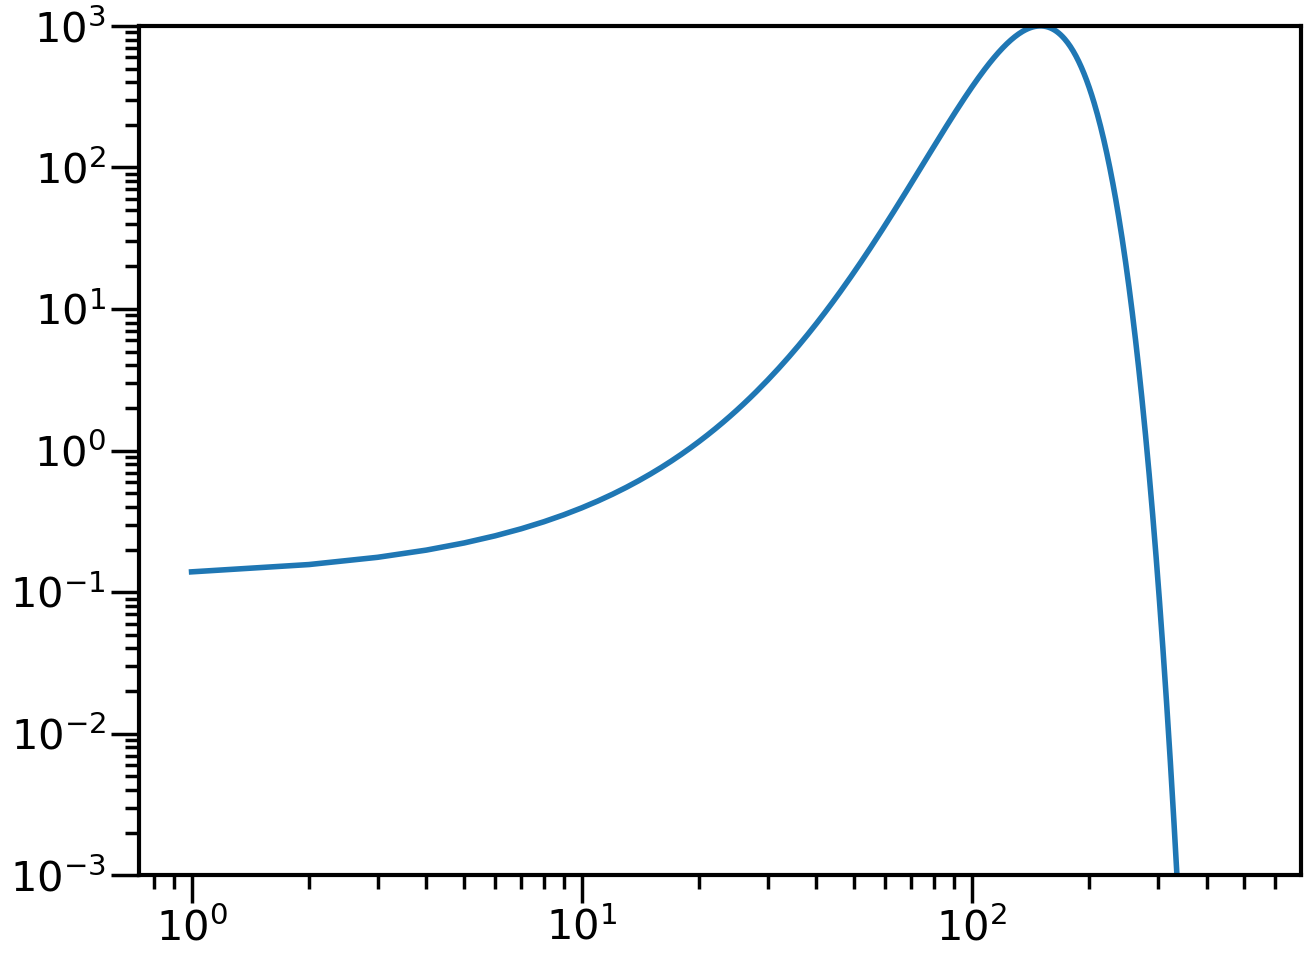

In [9]:
l0w=np.arange(512)+1
ww=1000*np.exp(-(l0w-150)**2/50**2)

loglog(l0w,ww)
ylim(1.e-3,1e3)

In [10]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')

In [11]:
window_cl_fact=1
if unit_window:
    window_cl_fact=0

In [12]:
z0=0.5
zl_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=10,use_window=use_window,nbins=1,window_cl_fact=window_cl_fact*.1,
                         f_sky=f_sky,nside=nside,unit_win=True)
zl_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=window_cl_fact+.1,#(1+ww/5),
                              f_sky=f_sky,nbins=n_source_bins,nside=nside)

ns0:  27.0
Win gen: step size 513


./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
ns0:  27.0
Win gen: step size 513
cl dict done


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [13]:
z0=1 #1087
zs_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=window_cl_fact,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,unit_win=False)

zs_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=(1+ww)*window_cl_fact+1,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside)

ns0:  27.000000000000004
Win gen: step size 513
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
ns0:  27.000000000000004
Win gen: step size 513
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [14]:
cl_t=hp.anafast(zs_bin1w[0]['window'])
cl_t2=hp.anafast(zs_bin1[0]['window'])
cl_t3=hp.anafast(zs_bin1[0]['window']-1)
cl_t4=hp.anafast(zl_bin1[0]['window'])

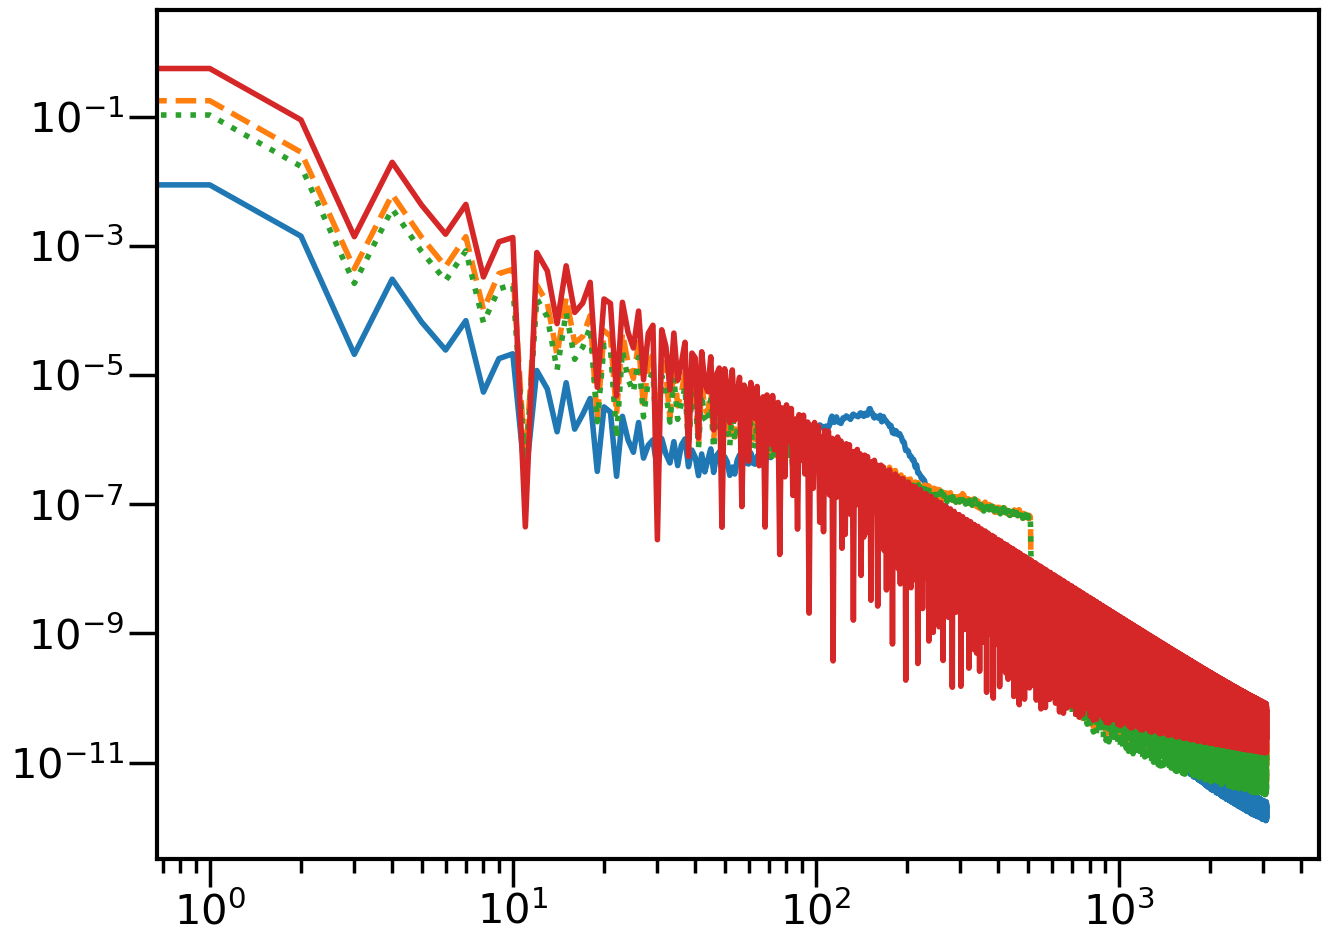

In [15]:
# loglog(hp.alm2cl(zs_bin1[0]['window_alm'],lmax=512))
# loglog(hp.alm2cl(zs_bin1w[0]['window_alm'],lmax=512))
loglog(cl_t)
loglog(cl_t2,'--')
loglog(cl_t3,':')
loglog(cl_t4)
# loglog(zs_bin1[0]['window_cl'])

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
10:02:46 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


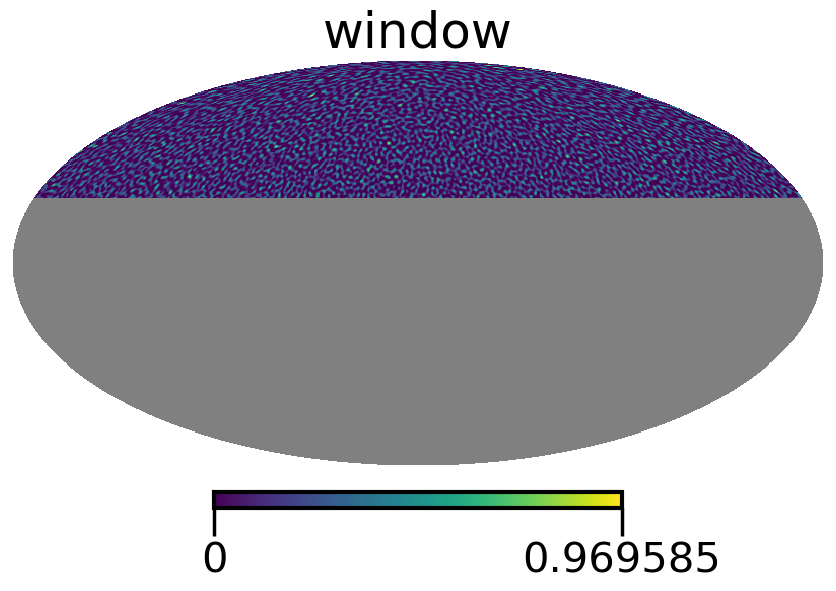

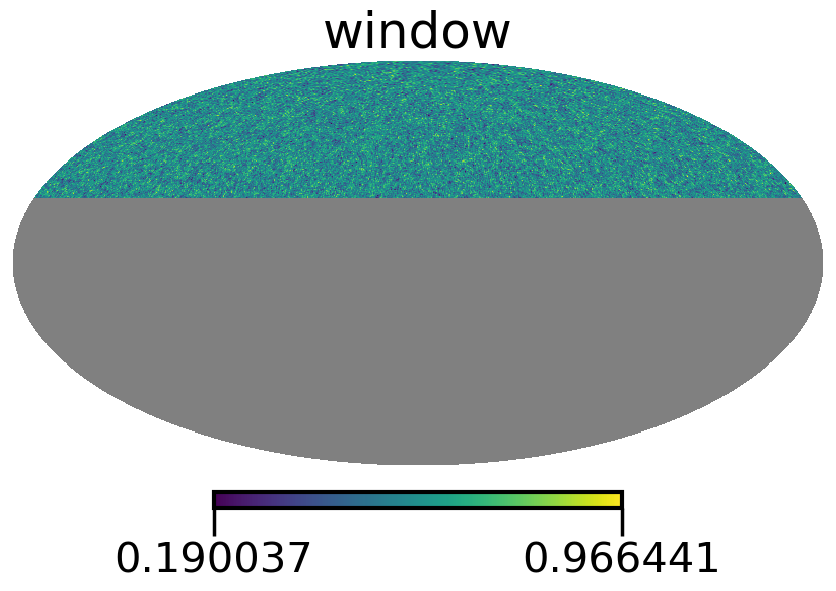

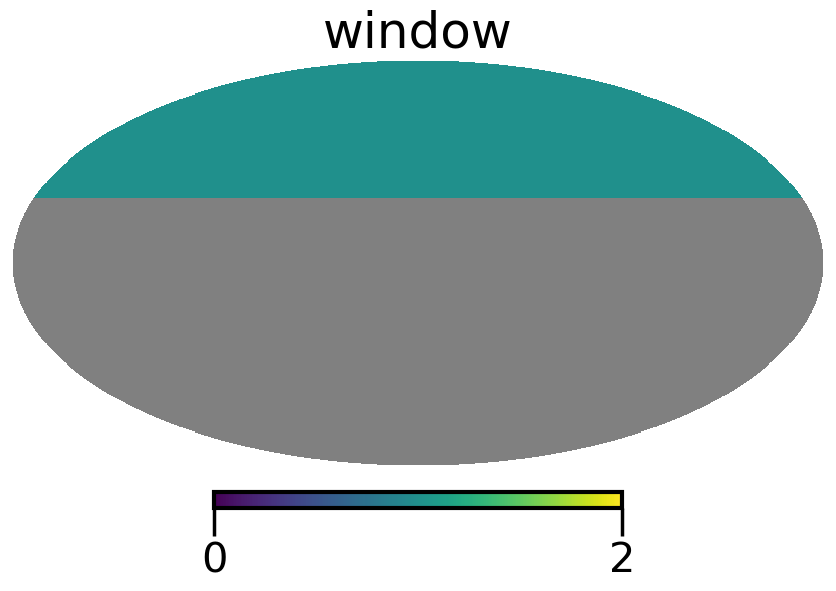

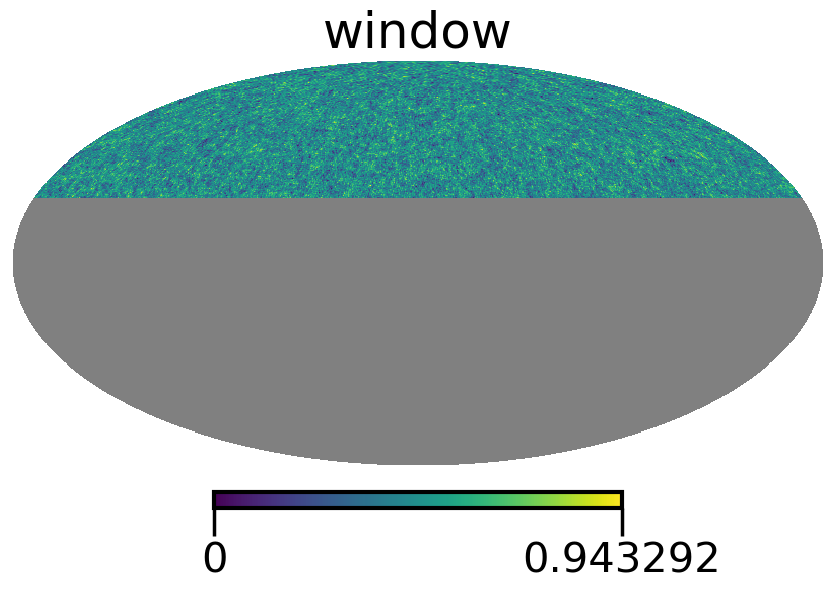

In [16]:
hp.mollview(zs_bin1w[0]['window'],title='window')
hp.mollview(zs_bin1[0]['window'],title='window')
hp.mollview(zl_bin1[0]['window'],title='window')
hp.mollview(zl_bin1w[0]['window'],title='window')

In [17]:
th_min=1./60
th_max=600./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

# HT_kwargs={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
WT_L=None
if do_xi:
    %time WT_L=wigner_transform(**WT_L_kwargs)

In [18]:
bin_xi=True

In [19]:
import window_utils
reload(window_utils)
from window_utils import *

import tracer_utils
reload(tracer_utils)
from tracer_utils import *


import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [20]:
do_cov=True
store_win=True

In [21]:
corrs=[corr_ll,corr_ggl,corr_gg]
window_lmax=1000  #0.5 % difference between 100 and 400, for unit window, 2% for realistic window

In [22]:
client

Client Scheduler: inproc://136.152.250.206/32197/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [23]:
import tracemalloc

In [25]:
tracemalloc.clear_traces()
tracemalloc.start()


t1=time.time()
kappa_win=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                 #Win=kappa_win.Win.Win
                 )

t2=time.time()
print('W done',t2-t1)
%time clG_win=kappa_win.cl_tomo(corrs=corrs) 
%time cl0_win=clG_win['stack'].compute()

if do_xi:
    %time xiWG_L=kappa_win.xi_tomo()
    %time xiW_L=xiWG_L['stack'].compute()

Win gen: step size 101
wigner_files: {0: 'temp/dask_wig3j_l6500_w1100_0_reorder.zarr', 2: 'temp/dask_wig3j_l6500_w1100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/32197/1' processes=1 cores=10>
got window cls, now to coupling matrices.
done coupling submatrix  0 18.705237865447998 2.743913412094116
done coupling submatrix  101 19.051133155822754 2.8684773445129395
done coupling submatrix  202 19.448065280914307 3.10139536857605
done coupling submatrix  303 19.60004687309265 3.3251795768737793
done coupling submatrix  404 19.625142335891724 3.5115509033203125
done coupling submatrix  505 19.94816279411316 3.7256548404693604
done coupling submatrix  606 20.256500959396362 3.8600800037384033
done coupling submatrix  707 20.357142686843872 4.0139734745025635
done coupling submatrix  808 20.54896903038025 4.227326154708862
done coupling submatrix  909 20.682966232299805 4.416041851043701
done coupling submatrix  1010 21.0990900

In [26]:
snapshot1 = tracemalloc.take_snapshot()

In [27]:
top_stats = snapshot1.statistics('lineno')
top_stats

[<Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=371>,)> size=282079560 count=17>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=372>,)> size=282079528 count=19>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=231>,)> size=211559304 count=6>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/numeric.py' lineno=1203>,)> size=75270496 count=10>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/einsumfunc.py' lineno=1346>,)> size=70532016 count=4>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=233>,)> size=70519768 count=2>,
 <Statistic traceback=<Traceback (<Frame filename='./tracer_utils.py' lineno=178>,)> size=4750720 count=6>,
 <Statistic traceback=<Traceback (<Frame filename='./tracer_utils.py' lineno=191>,)> size=4750560 count=4>,
 <Statistic traceback=<Traceback (<Frame file

In [28]:
stat = top_stats[3]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

10 memory blocks: 71.8 MiB
  File "/usr/lib/python3.7/site-packages/numpy/core/numeric.py", line 1203
    return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


In [29]:
l=kappa_win.window_l
Om_W=np.pi*4*f_sky
theta_win=np.sqrt(Om_W/np.pi)
l_th=l*theta_win
Win0=2*jn(1,l_th)/l_th
Win0=np.nan_to_num(Win0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [30]:
zs_bin1[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'AI', 'AI_z', 'mag_fact', 'lm', 'Gkernel', 'Gkernel_int', 'gkernel', 'gkernel_int', 'kernel_int', 'window', 'window_alm', 'window_cl'])

In [31]:
kappa_win.z_bins.keys()

dict_keys(['shear', 'galaxy'])

In [32]:
bi=(0,0)

In [33]:
R=kappa_win.Win.Win['cl'][corr_gg][bi]['M']/kappa_win.Win.Win['cl'][corr_ll][bi]['M']
R=np.nan_to_num(R)
x=R>0
R[x].max()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


1.7976931348623157e+308

In [34]:
kappa_win_w=cov_3X2(zs_bins=zs_bin1w,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1w,
            use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                   #Win=kappa_win_w.Win.Win
                   )

%time clG_win_w=kappa_win_w.cl_tomo(corrs=corrs) 
%time cl0_win_w=clG_win_w['stack'].compute()

if do_xi:
    %time xiWG_L_w=kappa_win_w.xi_tomo()
    %time xiW_L_w=xiWG_L_w['stack'].compute()

Win gen: step size 101
wigner_files: {0: 'temp/dask_wig3j_l6500_w1100_0_reorder.zarr', 2: 'temp/dask_wig3j_l6500_w1100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/32197/1' processes=1 cores=10>
got window cls, now to coupling matrices.
done coupling submatrix  0 18.700828552246094 2.751384735107422
done coupling submatrix  101 18.7011079788208 2.7916526794433594
done coupling submatrix  202 19.123618841171265 3.0805346965789795
done coupling submatrix  303 19.483457565307617 3.2585551738739014
done coupling submatrix  404 19.53697967529297 3.4055492877960205
done coupling submatrix  505 19.76696538925171 3.6014130115509033
done coupling submatrix  606 20.27654480934143 3.8266844749450684
done coupling submatrix  707 20.483234882354736 4.023895740509033
done coupling submatrix  808 20.571971893310547 4.2627480030059814
done coupling submatrix  909 20.91884136199951 4.501907110214233
done coupling submatrix  1010 20.76833939

In [35]:
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)

%time clG0=kappa0.cl_tomo(corrs=corrs) 
%time cl0=clG0['stack'].compute()

if do_xi:
    %time xiG_L0=kappa0.xi_tomo()
    %time xi_L0=xiG_L0['stack'].compute()

Win gen: step size 2970
cl dict done
CPU times: user 8.93 s, sys: 43.6 ms, total: 8.98 s
Wall time: 4.86 s
CPU times: user 6.41 s, sys: 457 ms, total: 6.87 s
Wall time: 1.2 s


In [36]:
zl_bin1[0]['lm']

395.48981405679393

In [37]:
kappa_win_w.Ang_PS.z.shape

(100,)

In [38]:
bi=(0,0)
cl0={'cl_b':{},'cov':{},'cl':{}}
cl0_win_w={'cl_b':{},'cov':{}}
cl0_win={'cl_b':{},'cov':{}}
for corr in corrs:
    cl0['cl_b'][corr]=clG0['cl_b'][corr][bi].compute()
    cl0['cl'][corr]=clG0['cl'][corr][bi].compute()
    cl0['cov'][corr]=clG0['cov'][corr+corr][bi+bi].compute()
    
    cl0_win['cl_b'][corr]=clG_win['cl_b'][corr][bi].compute()
    cl0_win['cov'][corr]=clG_win['cov'][corr+corr][bi+bi].compute()['final_b']
    
    cl0_win_w['cl_b'][corr]=clG_win_w['cl_b'][corr][bi].compute()
    cl0_win_w['cov'][corr]=clG_win_w['cov'][corr+corr][bi+bi].compute()['final_b']

In [39]:
import binning
reload(binning)
from binning import *
M_binnings={}
M_binning_utils={}
Mw_binning_utils={}
for corr in corrs:
    M_binnings[corr]=binning()
    wt_b=1./cl0['cl_b'][corr]
    wt0=cl0['cl'][corr]
    M_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)
    Mw_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)

[]

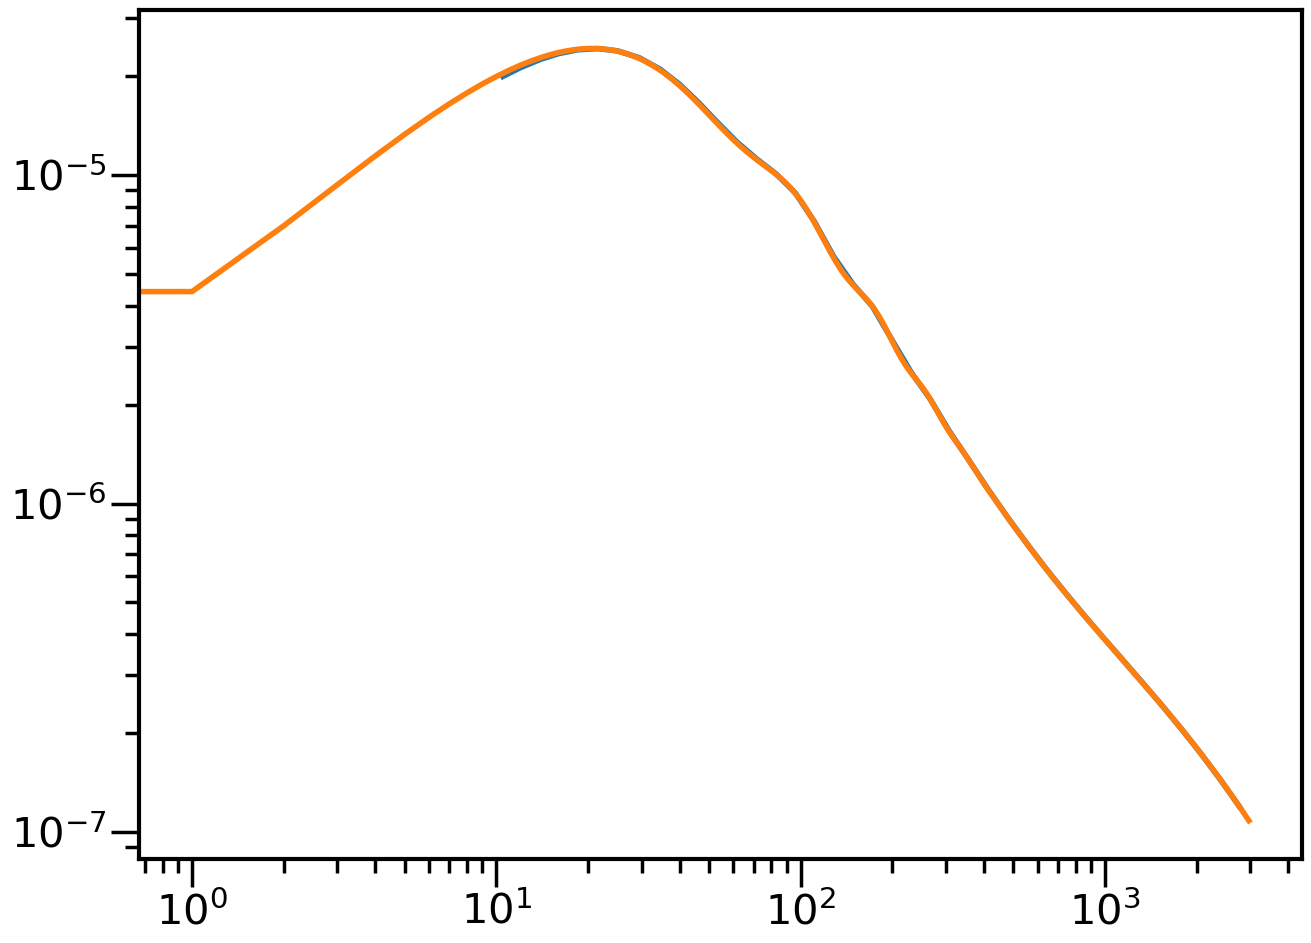

In [40]:
plot(lb,cl0['cl_b'][corr_gg])
plot(l0,cl0['cl'][corr_gg])
loglog()

In [41]:
mask=zs_bin1[0]['window']>-1.e-20

In [42]:
win2=zs_bin1[0]['window']/zs_bin1[0]['window']
win2[~mask]=hp.UNSEEN
win2[mask]=1.
cl_t2=hp.anafast(win2)

In [43]:
np.arange(len(cl_t2))

array([   0,    1,    2, ..., 3069, 3070, 3071])

In [44]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))

In [45]:
def bin_coupling_M(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    Q=bin_M.T*np.pi*2/(l2)
    P=bin_M.T*(l2)/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [46]:
def bin_coupling_M2(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    
    Q=bin_M.T*np.pi*2/(l2)**2
    P=bin_M.T*(l2)**2/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [47]:
seed=12334
def get_clsim2(clg0,window,mask,kappa_class,coupling_M,coupling_M_inv,ndim,i):
    print(i)
    local_state = np.random.RandomState(seed+i)
    cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)

    if ndim>1:
        cl_map[0]*=window['galaxy']
        cl_map[0][mask['galaxy']]=hp.UNSEEN
        cl_map[1]*=window['shear'] #shear_1
        cl_map[2]*=window['shear']#shear_2
        cl_map[1][mask['shear']]=hp.UNSEEN
        cl_map[2][mask['shear']]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
        clpi=clpi[:,l]
        clpi=clpi[[0,1,3],:]
#             for i in np.arange(6):

    else:
        cl_map*=window
        cl_map[mask]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]
        
    del cl_map

    if ndim>1:
        clpi[0]-=(np.ones_like(clpi[0])*kappa_class.SN[corr_gg][:,0,0])@coupling_M[corr_gg]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M[corr_ll]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M['shear_B']*use_shot_noise #remove B-mode leakage

        clgi=[clpi[0]@coupling_M_inv[corr_gg],
              clpi[1]@coupling_M_inv[corr_ll],
              clpi[2]@coupling_M_inv[corr_ggl]]
    else:
        clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
        clgi=clpi@coupling_M_inv
    clgi=np.array(clgi)
    return [clpi.T,clgi.T]



In [48]:
def calc_sim_stats(sim=[],sim_truth=[],PC=False):
    sim_stats={}
    sim_stats['std']=np.std(sim,axis=0)    
    sim_stats['mean']=np.mean(sim,axis=0)
    sim_stats['median']=np.median(sim,axis=0)
    sim_stats['percentile']=np.percentile(sim,[16,84],axis=0)
    sim_stats['skew']=skew(sim,axis=0)
    sim_stats['kurt']=kurtosis(sim,axis=0)
    sim_stats['cov']=np.cov(sim,rowvar=0)
    
    if not PC:
        try:
            sim_stats['cov_ev'],sim_stats['cov_evec']=np.linalg.eig(sim_stats['cov'])
            sim_stats['PC']={}
            sim_stats['PC']['data']=(sim_stats['cov_evec'].T@sim.T).T
            sim_stats['PC']['stats']=calc_sim_stats(sim=sim_stats['PC']['data'],PC=True)
        except Exception as err:
            print(err)
            sim_stats['PC']=err
    else:
        sim_truth=sim_stats['mean']
    
    sim_stats['percetile_score']=np.zeros_like(sim_stats['std'])
    if len(sim_stats['std'].shape)==1:
        for i in np.arange(len(sim_stats['std'])):
            sim_stats['percetile_score'][i]=percentileofscore(sim[:,i],sim_truth[i])
    elif len(sim_stats['std'].shape)==2:
        for i in np.arange(len(sim_stats['std'])):
            for i_dim in np.arange(2):
                for j_dim in np.arange(2):
                    sim_stats['percetile_score'][i][i_dim,j_dim]=percentileofscore(sim[:,i,i_dim,j_dim],
                                                                                   sim_truth[i,i_dim,j_dim])
    else:
        sim_stats['percetile_score']='not implemented for ndim>2'
    return sim_stats
    
def sim_cl_xi(Rsize=150,do_norm=False,cl0=None,kappa_class=None,fsky=f_sky,zbins=None,use_shot_noise=True,
             convolve_win=False,nside=nside,use_cosmo_power=True):
    l=kappa_class.l
    shear_lcut=l>=2
    
    l_bins=kappa_class.l_bins
    dl=l_bins[1:]-l_bins[:-1]
    nu=(2.*l+1.)*fsky
    
    coupling_M={}
    coupling_M4={}
    coupling_M_binned={}
    coupling_M_binned2={}
    coupling_M_binned2wt={}
    coupling_M4_binned={}
    coupling_M4_binned2={}
    
    coupling_M_inv={}
    coupling_M_binned_inv={}
    coupling_M_binned2_inv={}
    coupling_M_binned2wt_inv={}
    mask={}
    window={}
    if convolve_win:
        nu=2.*l+1.
        
        for tracer in kappa_class.z_bins.keys():
            window[tracer]=kappa_class.z_bins[tracer][0]['window']
            mask[tracer]=window[tracer]==hp.UNSEEN
        for corr in corrs:
            coupling_M[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M']
            if corr==corr_ll:
                coupling_M['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B']
            coupling_M_binned[corr]=bin_coupling_M(kappa_class,coupling_M[corr])
            coupling_M_binned2[corr]=kappa_class.binning.bin_2d(cov=coupling_M[corr],bin_utils=kappa_class.cl_bin_utils) 
            coupling_M_binned2[corr]*=dl
            
#             coupling_M_binned2wt[corr]=M_binnings[corr].bin_2d(cov=coupling_M[corr],bin_utils=M_binning_utils[corr])
#             coupling_M_binned2wt[corr]*=dl
            
            coupling_M_binned2wt[corr]=M_binnings[corr].bin_2d_coupling(cov=coupling_M[corr].T,bin_utils=M_binning_utils[corr])
            coupling_M_binned2wt[corr]=coupling_M_binned2wt[corr].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.

            
#             coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
#             coupling_M4_binned[corr]=bin_coupling_M(kappa_class,coupling_M4[corr])
#             coupling_M4_binned2[corr]=kappa_class.binning.bin_2d(cov=coupling_M4[corr],bin_utils=kappa_class.cl_bin_utils) 
#             coupling_M4_binned2[corr]*=dl
#         kappa_class.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils)
#             print(corr,coupling_M[corr])
            
            cut=l>0
            if 'shear' in corr:
                cut=shear_lcut 
            coupling_M_inv[corr]=np.zeros_like(coupling_M[corr])
            coupling_M_inv[corr][:,cut][cut,:]=np.linalg.inv(coupling_M[corr][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
            
            coupling_M_binned_inv[corr]=np.linalg.inv(coupling_M_binned[corr])
            coupling_M_binned2_inv[corr]=np.linalg.inv(coupling_M_binned2[corr])
            coupling_M_binned2wt_inv[corr]=np.linalg.inv(coupling_M_binned2wt[corr])
    outp={}
    win=0
    clp_shear_B=None
    if cl0 is None:
        cl0={}
        clp0={}
        clG0=kappa_class.cl_tomo() 
        for corr in kappa_class.corrs:
            cl0[corr]=clG0['cl'][corr][(0,0)].compute()
            clp0[corr]=clG0['cl_b'][corr][(0,0)].compute()
    clg0={}
    for corr in kappa_class.corrs: #ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        shot_noise=0
        if corr[0]==corr[1]:
            shot_noise=kappa_class.SN[corr][:,0,0]
        shot_noise=shot_noise*use_shot_noise
        clg0[corr]=cl0[corr]*use_cosmo_power+shot_noise
        if corr==corr_ll:
            clg0['shear_B']=cl0[corr]*0+shot_noise
            clp_shear_B=shot_noise@coupling_M[corr_ll]+cl0[corr_ll]@coupling_M['shear_B']
    ndim=len(kappa_class.corrs)
    print('ndim:',ndim)
    outp['clg0_0']=clg0.copy()
    outp['ndim']=ndim
    if ndim>1:
        clg0=(clg0[corr_gg],clg0[corr_ll],clg0['shear_B'],clg0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
    else:
        clg0=clg0[corr_gg]
    
    SN=kappa_class.SN
    sim_cl_shape=(Rsize,len(kappa_class.l),ndim)
    
    clp=np.zeros(sim_cl_shape,dtype='float32')
    clg=np.zeros(sim_cl_shape,dtype='float32')
    clpB=np.zeros(sim_cl_shape,dtype='float32')
    lmax=max(l)
    lmin=min(l)
    
    
    clg_b=None
    clp_b=None
    clpB_b=None
    nu_b=None
    if l_bins is not None:
        clg0_b={corr: kappa_class.binning.bin_1d(xi=cl0[corr],bin_utils=kappa_class.cl_bin_utils) for corr in kappa_class.corrs} 
        ll=kappa_class.cl_bin_utils['bin_center']
        sim_clb_shape=(Rsize,len(ll),ndim)
        nu_b=(2.*ll+1.)*fsky*(l_bins[1:]-l_bins[:-1])
        clg_b=np.zeros(sim_clb_shape,dtype='float32')
        clg_bM=np.zeros(sim_clb_shape,dtype='float32') #master
        clg_bM2=np.zeros(sim_clb_shape,dtype='float32') #different master
        clg_bM2wt=np.zeros(sim_clb_shape,dtype='float32')# weighted different master
        clp_b=np.zeros(sim_clb_shape,dtype='float32')
        clpB_b=np.zeros(sim_clb_shape,dtype='float32')
        
        binning_func=kappa_class.binning.bin_1d
        binning_utils=kappa_class.cl_bin_utils
        
        clp_shear_B_b=binning_func(xi=clp_shear_B,bin_utils=binning_utils)
        
    corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
    seed=12334
    def get_clsim(i):
        print('doing map: ',i)
        local_state = np.random.RandomState(seed+i)
        cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)
        
        if ndim>1:
            cl_map[0]*=window['galaxy']
            cl_map[0][mask['galaxy']]=hp.UNSEEN
            cl_map[1]*=window['shear'] #shear_1
            cl_map[2]*=window['shear']#shear_2
            cl_map[1][mask['shear']]=hp.UNSEEN
            cl_map[2][mask['shear']]=hp.UNSEEN
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
            clpi=clpi[:,l]
            clpi_B=clpi[[2,4,5],:]
            clpi=clpi[[0,1,3],:]
            
#             for i in np.arange(6):
            
            
        else:
            cl_map*=window
            cl_map[mask]=hp.UNSEEN
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]

        if ndim>1:
            clpi[0]-=(np.ones_like(clpi[0])*SN[corr_gg][:,0,0])@coupling_M[corr_gg]*use_shot_noise
            clpi[1]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M[corr_ll]*use_shot_noise
            clpi[1]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M['shear_B']*use_shot_noise #remove B-mode 
            
            clgi=[clpi[0]@coupling_M_inv[corr_gg],
                  clpi[1]@coupling_M_inv[corr_ll],
                  clpi[2]@coupling_M_inv[corr_ggl]]
        else:
            clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
            clgi=clpi@coupling_M_inv
        clgi=np.array(clgi)
        if l_bins is not None:
            corr_t=[corr_gg,corr_ll,corr_ggl]
            sim_clb_shape=(len(ll),ndim)
            clg_b=np.zeros(sim_clb_shape,dtype='float32')
            clg_bM=np.zeros(sim_clb_shape,dtype='float32')
            clg_bM2=np.zeros(sim_clb_shape,dtype='float32')
            clg_bM2wt=np.zeros(sim_clb_shape,dtype='float32')
            clp_b=np.zeros(sim_clb_shape,dtype='float32')
            clpB_b=np.zeros(sim_clb_shape,dtype='float32')
            for ii in np.arange(ndim):
                clg_b[:,ii]=binning_func(xi=clgi[ii],bin_utils=binning_utils)
                clp_b[:,ii]=binning_func(xi=clpi[ii],bin_utils=binning_utils)
                clpB_b[:,ii]=binning_func(xi=clpi_B[ii],bin_utils=binning_utils)
                clg_bM[:,ii]=clp_b[:,ii]@coupling_M_binned_inv[corr_t[ii]] #be careful with ordering as coupling matrix is not symmetric
                clg_bM2[:,ii]=clp_b[:,ii]@coupling_M_binned2_inv[corr_t[ii]]
                clg_bM2wt[:,ii]=clp_b[:,ii]@coupling_M_binned2wt_inv[corr_t[ii]]
            return clpi.T,clgi.T,clg_b,clp_b,clg_bM,clg_bM2,clg_bM2wt,clpi_B.T,clpB_b
        else:
            return clpi.T,clgi.T
    
    def comb_maps(futures):
        for i in np.arange(Rsize):
            x=futures[i]#.compute()
            clp[i,:,:]+=x[0]
            clg[i,:,:]+=x[1]
        return clp,clg 
    
    print('generating maps')
    if convolve_win:
        futures={}
#         for i in np.arange(Rsize):
#             futures[i]=dask.delayed(get_clsim)(i)  
#         print(futures)
#         clpg=dask.delayed(comb_maps)(futures)
#         clpg.compute()
        i=0
        j=0
        step=min(5,Rsize)
        funct=partial(get_clsim2,clg0,window,mask,SN,coupling_M,coupling_M_inv,ndim)
        while j<Rsize:
            futures={}
            for ii in np.arange(step):
                futures[ii]=delayed(get_clsim)(i+ii)  
            futures=client.compute(futures)
            for ii in np.arange(step):
                if l_bins is None:
                    clp[i,:],clg[i,:]=futures.result()[ii]
                else:
                    clp[i,:],clg[i,:],clg_b[i,:],clp_b[i,:],clg_bM[i,:],clg_bM2[i,:],clg_bM2wt[i,:],clpB[i,:],clpB_b[i,:]=futures.result()[ii]
                i+=1
            print('done map ',i)
            del futures
            client.restart()
            j+=step
        
    print('done generating maps')
    
            
    outp['clg_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clg_b[:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    outp['clg_bM_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clg_bM[:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    outp['clg_bM2_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clg_bM2[:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    outp['clg_bM2wt_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clg_bM2wt[:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    outp['clp_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clp_b[:,:,ii],sim_truth=clp_b[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    outp['clpB_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clpB_b[:,:,ii],sim_truth=clpB_b[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    
    outp['clg_b_stats']=outp['clg_b_stats'].result()
    outp['clg_bM_stats']=outp['clg_bM_stats'].result()
    outp['clg_bM2_stats']=outp['clg_bM2_stats'].result()
    outp['clg_bM2wt_stats']=outp['clg_bM2wt_stats'].result()
    outp['clp_b_stats']=outp['clp_b_stats'].result()
    outp['clpB_b_stats']=outp['clpB_b_stats'].result()
        
#         outp['clp_b_stats']=calc_sim_stats(sim=clp_b,sim_truth=clp_b.mean(axis=0))
#     xiN=np.zeros((Rsize,len(xi)))
#     xig=np.zeros((Rsize,len(xi)))
#     xigB=np.zeros((Rsize,len(r_bins)-1))
#     xiNB=np.zeros((Rsize,len(r_bins)-1))
#     for i in np.arange(Rsize):
#         r,xig[i,:]=HT.projected_correlation(k_pk=l,pk=clg[i,:],j_nu=0,taper=True,**taper_kw)
#         rb,xigB[i,:]=HT.bin_mat(r=r,mat=xig[i,:],r_bins=r_bins)
#         if do_clN:
#             r,xiN[i,:]=HT.projected_correlation(k_pk=l,pk=clN[i,:],j_nu=0,taper=True,**taper_kw)
#             rb,xiNB[i,:]=HT.bin_mat(r=r,mat=xiN[i,:],r_bins=r_bins)
#     outp['xi_truth']=xi_truth
#    outp['rb']=rb
    outp['clg']=clg
    outp['clp']=clp
    outp['clpB']=clpB
    outp['clg_b']=clg_b
    outp['clg_bM']=clg_bM
    outp['clg_bM2']=clg_bM2
    outp['clg_bM2wt']=clg_bM2wt
    outp['clp_b']=clp_b
    outp['clpB_b']=clpB_b
    outp['clg0']=clg0
    outp['cl0']=cl0
    outp['clp0']=clp0
    outp['clp_shear_B_b']=clp_shear_B_b
    outp['clp_shear_B']=clp_shear_B
#     outp['clN']=clN
#     outp['xig']=xig
#     outp['xigB']=xigB
#     outp['xiNB']=xiNB
#     outp['xiN']=xiN
    clg0_2=np.array(clg0)[[0,1,3],:]
    outp['clg_stats']={corr_t[ii]: calc_sim_stats(sim=clg[:,:,ii],sim_truth=clg0_2[ii]) for ii in np.arange(ndim)}#calc_sim_stats(sim=clg,sim_truth=clg0)
    outp['clp_stats']={corr_t[ii]: calc_sim_stats(sim=clp[:,:,ii],sim_truth=clp[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)}#     calc_sim_stats(sim=clp,sim_truth=clp.mean(axis=0))

#     outp['xig_stats']=calc_sim_stats(sim=xig,sim_truth=xi)
#     if convolve_win:
#         outp['xig_stats0']=calc_sim_stats(sim=xig,sim_truth=xi0)
#     rb,xiB=HT.bin_mat(r=r,mat=xi_truth,r_bins=r_bins)
#     outp['xigB_stats']=calc_sim_stats(sim=xigB,sim_truth=xiB)
#     if do_clN:
#         outp['xiN_stats']=calc_sim_stats(sim=xiN,sim_truth=xi_truth)
#         outp['xiNB_stats']=calc_sim_stats(sim=xiNB,sim_truth=xiB)

    outp['size']=Rsize
    outp['fsky']=fsky
    outp['nu']=nu
    outp['nu_b']=nu_b
    outp['l_bins']=l_bins
    
    outp['coupling_M']=coupling_M
    outp['coupling_M_binned']=coupling_M_binned
    outp['coupling_M_binned2']=coupling_M_binned2
    outp['coupling_M_binned2wt']=coupling_M_binned2wt
    
    outp['coupling_M_inv']=coupling_M_inv
    outp['coupling_M_binned_inv']=coupling_M_binned_inv
    outp['coupling_M_binned2_inv']=coupling_M_binned2_inv
    outp['coupling_M_binned2wt_inv']=coupling_M_binned2wt_inv
    outp['use_shot_noise']=use_shot_noise
    
    
    return outp

#cov=np.diag(cl**2/nu)

In [49]:
clg0=clG0['cl'][corrs[0]][(0,0)].compute()

In [50]:
client.restart()

Client Scheduler: inproc://136.152.250.206/32197/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [51]:
shot_noise=kappa_win.SN[corrs[0]][0,0,0]

In [52]:
nsim=1000

In [53]:
nsim,nside

(1000, 1024)

In [55]:
use_shot_noise=False 
use_cosmo_power=True

In [56]:
fname='./tests/non_gaussian_likeli_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(f_sky)
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
fname+='.pkl'

print(fname)

./tests/non_gaussian_likeli_sims1000_ns1024_lmax2969_wlmax1000_fsky0.3_noSN.pkl


In [57]:
tracemalloc.clear_traces()
tracemalloc.start()
cl_sim_W=sim_cl_xi(Rsize=nsim,do_norm=False,#cl0=clG0['cl'][corrs[0]][(0,0)].compute(),
          kappa_class=kappa_win,fsky=f_sky,use_shot_noise=use_shot_noise,use_cosmo_power=use_cosmo_power,
             convolve_win=True,nside=nside)
snapshot1 = tracemalloc.take_snapshot()

cl dict done
ndim: 3
generating maps
doing map: doing map:  0doing map: 
 3doing map:  2
doing map:   1
4

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) -> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  5
doing map: doing map: doing map: doing map: doing map:  14
 12
   11
10
13
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) -> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin

done map  15
doing map: doing map: doing map: doing map:  18
 17
doing map:  19
 15
 16
Sigma is 0.000000 arcmin (0.000000 rad

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  105
doing map: doing map: doing map: doing map: doing map:  107
 106
  108
 109
105
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  110
doing map: doing map: doing map: doing map: doing map:  112
 110
 114
 113
 111
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) -> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  200
doing map: doing map: doing map: doing map:  201
 203
 204
doing map:  202
 200
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  205
doing map: doing map: doing map: doing map: doing map:  206
  207
 208
205
 209
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  295
doing map: doing map: doing map: doing map:  295
doing map:  298
 296
 299
 297
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  300
doing map: doing map: doing map: doing map: doing map:  300
  304
 303302
 301

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  390
doing map: doing map:  393
 394
doing map: doing map: doing map:  390
 391
 392
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  395
doing map: doing map: doing map: doing map: doing map:  397
 398
  399
395
 396
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  485
doing map: doing map: doing map: doing map: doing map:  487
 488
 486
 485
 489
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin


-> fwhm is 0.000000 arcmin-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  490
doing map: doing map: doing map: doing map:  494
doing map:  491
   492
493
490
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


-> fwhm is 0.000000 arcmin-> fwhm is 0.000000 arcmin

done map  580
doing map: doing map: doing map: doing map: doing map:  580
  581
 584
582 583

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  585
doing map: doing map: doing map: doing map: doing map:    586
 587
588589

 585
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  675
doing map: doing map: doing map: doing map: doing map:  676
  675
679
  678
677
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  680
doing map: doing map: doing map: doing map:  683
 681
doing map:  680
  682
684
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) -> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  770
doing map: doing map:  doing map:  771
 774
doing map: doing map:  772
 770
773
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  775
doing map: doing map:  775
 777
doing map: doing map: doing map:  776
 779
 778
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  865
doing map: doing map: doing map: doing map: doing map:  868
   867
 866
869865

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  870
doing map: doing map: doing map: doing map:  871
 872
 873
 doing map:  870
874
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) -> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin

done map  960
doing map: doing map: doing map: doing map: doing map:  963
  960
964
  961
962
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  965
doing map: doing map: doing map: doing map: doing map:  969
 968
  967
965
 966
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1121: RuntimeWarning: invalid value encountered in true_divide
  lambda m2, m3: m3 / m2**1.5,


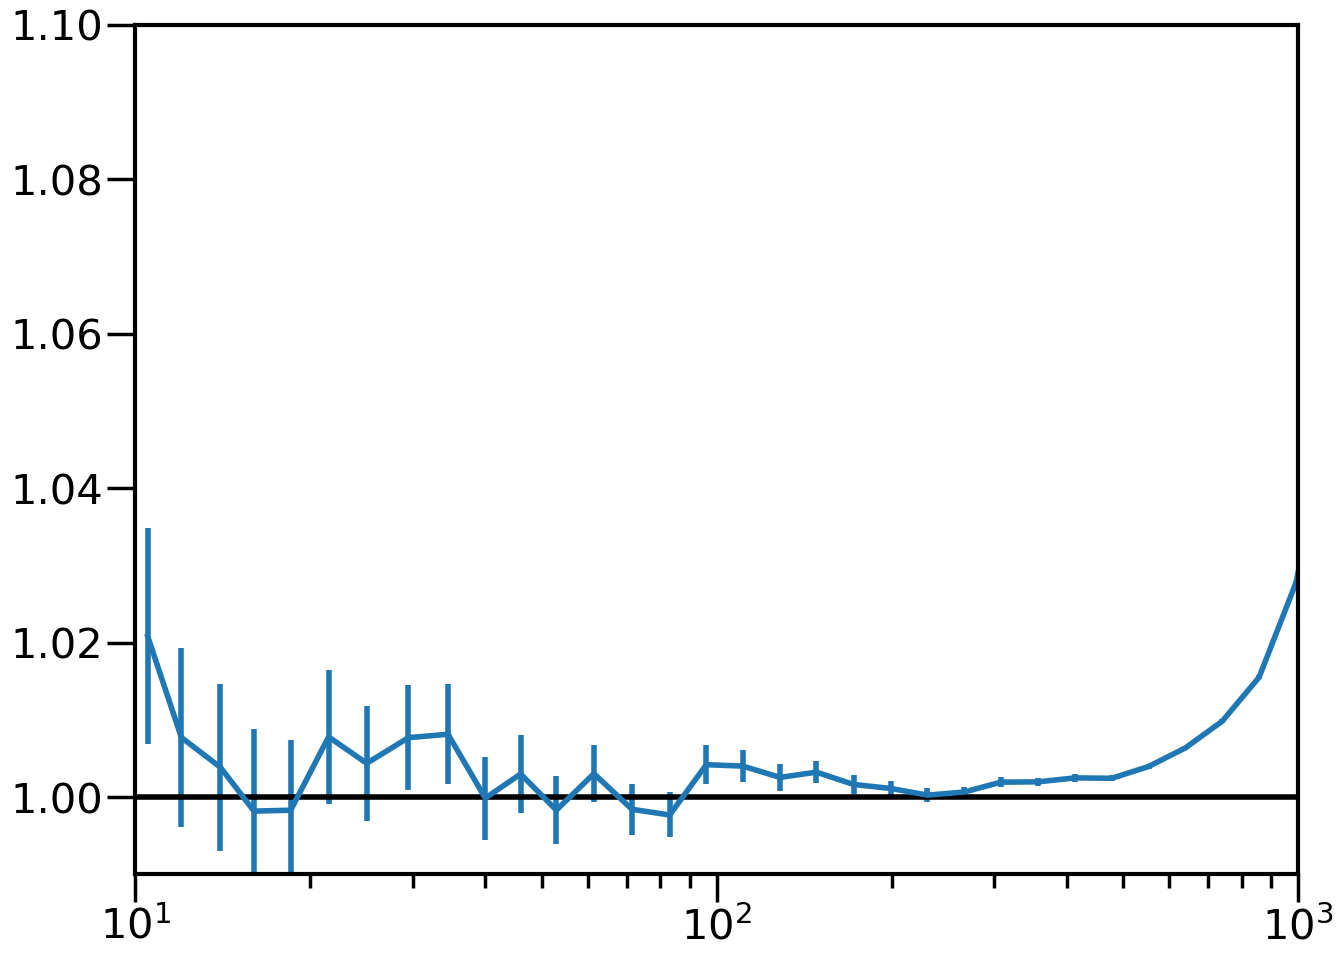

In [58]:
# clt=cl0['cl'][corr_ll]
# cl_shear_B=kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll]+clt@cl_sim_W['coupling_M']['shear_B']
# cl_shear_B_b=M_binnings[corr_ll].bin_1d(xi=cl_shear_B,bin_utils=M_binning_utils[corr_ll])
errorbar(lb,cl_sim_W['clpB_b_stats'][corr_gg]['mean']/cl_sim_W['clp_shear_B_b'],cl_sim_W['clpB_b_stats'][corr_gg]['std']/cl_sim_W['clp_shear_B_b']/sqrt(nsim))
# plot(lb,cl_shear_B_b)
xscale('log')
# yscale('log')
ylim(0.99,1.1)
xlim(10,1000)
hlines(1,10,1000)

In [59]:
snapshot1 = tracemalloc.take_snapshot()

In [60]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

17 memory blocks: 269.0 MiB
  File "./window_utils.py", line 371
    result0['M1324']={wp: np.zeros((nl,nl),dtype='float32') for wp in W_pm[1324]}


In [61]:
client.restart()

Client Scheduler: inproc://136.152.250.206/32197/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [ ]:
cl_sim_Ww=sim_cl_xi(Rsize=nsim,do_norm=False,#cl0=clG0['cl'][corrs[0]][(0,0)].compute(),
          kappa_class=kappa_win_w,fsky=f_sky,use_shot_noise=use_shot_noise,
             convolve_win=True,nside=nside)

cl dict done
ndim: 3
generating maps
doing map: doing map: doing map: doing map: doing map:  3
  0
1
  2
4
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  5
doing map: doing map: doing map: doing map: doing map:  5
 7
  9
6
 8
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  10
doing map: doing map: doing map: doing map: doing map:  12
 13
 10
 11
 14
Sigma is 0.000000 arcmin (0.000000 rad) 
->

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  100
doing map: doing map: doing map: doing map: doing map:  104
 101
  102
 100
103
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  105
doing map: doing map: doing map: doing map: doing map:   109
106
 105
 107
 108
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcminSigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  195
doing map: doing map: doing map: doing map: doing map:  198
 195
 199
  196
197
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  200
doing map: doing map: doing map:  202
 201
 203
doing map:  204
doing map:  200
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  290
doing map: doing map: doing map: doing map: doing map:  290
 294
 291
 292
 293
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  295
doing map: doing map: doing map: doing map:  299
 297
doing map:  296
 298
 295
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 


-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin-> fwhm is 0.000000 arcmin

done map  385
doing map: doing map: doing map: doing map: doing map:  388
 385
   387
389
386
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  390
doing map: doing map:  391
doing map:  393
doing map:  394
 392
doing map:  390
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  480
doing map:  480
doing map: doing map:  481
doing map:  484
 483
doing map:  482
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  485
doing map: doing map:  485
doing map: doing map:  486
 487
doing map:  489
 488
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmi

Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcminSigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 


-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  575
doing map: doing map: doing map:  578
doing map:  577
 576
 doing map:  575
579
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  580
doing map: doing map: doing map: doing map: doing map:  580
 584
  581
583
 582
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  670
doing map: doing map: doing map:  674
 671
doing map: doing map:  673
 670
 672
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  675
doing map: doing map: doing map: doing map: doing map:  679
 675
 678
  677
676
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arc

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  765
doing map: doing map: doing map: doing map: doing map:  766
 768
 769
  765
767
done map  770
doing map: doing map: doing map: doing map:  772
 774
 773
doing map:  771
 770
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcminSigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin

done map  775
doing map: doing map: doing map:  777
 778
doing map: doing map:  776
 779
 775
Sigma is 0.000000 arcmin (0.000000 rad


-> fwhm is 0.000000 arcmin
done map  860
doing map: doing map: doing map: doing map:  861
 864
 863
 862
doing map:  860
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 


-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
done map  865
doing map: doing map: doing map: doing map:  865
 867
 868
 doing map:  869
866
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcminSigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin

-> fwhm is 0.000000 arcmin
done map  870
doing map: doing map: doing map: doing map: doing map:  874
 873
 870
 871
 872
Sigma is 0

In [ ]:
outp={}
outp['simW']=cl_sim_W
outp['zs_bin1']=zs_bin1
outp['zl_bin1']=zl_bin1
outp['cl0']=cl0
outp['cl0_win']=cl0_win

outp['simWw']=cl_sim_Ww
outp['zs_bin1w']=zs_bin1w
outp['zl_bin1w']=zl_bin1w
outp['cl0_win_w']=cl0_win_w


with open(fname,'wb') as f:
    pickle.dump(outp,f)
written=True

In [ ]:
# #fname='./tests/non_gaussian_likeli_sims_'+str(nside)+'.pkl'
with open(fname, 'rb') as handle:
    outp = pickle.load(handle)

cl_sim_W=outp['simW']
cl_sim_Ww=outp['simWw']
zs_bin1=outp['zs_bin1']
zs_bin1w=outp['zs_bin1w']
zl_bin1=outp['zl_bin1']
zl_bin1w=outp['zl_bin1w']
cl0=outp['cl0']
cl0_win_w=outp['cl0_win_w']
cl0_win=outp['cl0_win']



In [ ]:
()+corr_gg


In [ ]:
corr=corr_ll
bi=(0,0)

In [ ]:
labels={}
labels[corr_gg]=r'$gg$'
labels[corr_ll]=r'$\gamma\gamma$'
labels[corr_ggl]=r'$g \gamma$'

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    plot(lb,f*cl0_win['cl_b'][corr],label=labels[corr])
    
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
ylim(1.e-8,1.e-3)
xlim(10,nside)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    plot(lb,f*cl0_win['cl_b'][corr],label=labels[corr],c=color)
    
    i+=1
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
#     yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'p-$C_\ell$ (W1)')
    legend()
    if corr==corr_ll:
        ylim(0,3.e-7)
    xlim(10,nside)
    show()

In [ ]:
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll])
plot(kappa0.l,(kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M']['shear_B']))
loglog()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in [corr_ll]:
    color=colors[i%len(colors)]
    errorbar(lb,cl_sim_W['clp_b_stats'][corr]['mean']-cl0_win['cl_b'][corr],cl_sim_W['clp_b_stats'][corr]['std'],fmt='o-',c=color)
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M']['shear_B'],'r-')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll],'c-')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
xlim(10,nside)
# xlim(50,200)
# ylim(1.e-8,1.e-3)

In [ ]:
cl0_win['cl_b'][corr]

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
#     errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl_sim_W['clp0'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl_sim_W['clp0'][corr]/30,
#              fmt='o-',c=color,label=labels[corr])
    errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl0_win['cl_b'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl0_win['cl_b'][corr]/sqrt(nsim),
             fmt='o-',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
hlines(1,10,2000)
legend(ncol=3)
ylim(0.95,1.05)
xlim(10,nside)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_Ww['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std']/sqrt(nsim),fmt='o',c=color)
    errorbar(lb,f*cl_sim_Ww['clp0'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W2)')
# xlim(10,1000)
ylim(1.e-12,1.e-6)
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_Ww['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o',c=color)
    errorbar(lb,f*cl_sim_Ww['clp0'][corr],c=color,label=labels[corr])
    i+=1
    # plot(lb,f*cl0_win_w['cl_b'][:39])
    # plot(lb,f*cl0_win['cl_b'])
    # plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
#     yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'p-$C_\ell$ (W2)')
    xlim(10,1000)
    if corr==corr_ll:
        ylim(0,1.e-8)
    legend()
    show()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),cl_sim_Ww['clp_b_stats'][corr]['mean']/cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std']/cl_sim_Ww['clp0'][corr]/sqrt(1000),
             fmt='o-',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W2)')
legend()
ylim(0.95,1.05)
xlim(10,2000)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in [corr_ll]:
    color=colors[i%len(colors)]
    errorbar(lb,cl_sim_Ww['clp_b_stats'][corr]['mean']-cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std']/sqrt(nsim),fmt='o-',c=color)
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M']['shear_B'],'r-')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M'][corr_ll],'c-')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
# xlim(50,200)
# ylim(1.e-8,1.e-3)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in [corr_gg]:
    color=colors[i%len(colors)]
    errorbar(lb,cl_sim_Ww['clp_b_stats'][corr]['mean']-cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o-',c=color)
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
# plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M']['shear_B'],'r-')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M'][corr_gg],'c-')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_Ww['clg_bM_stats'][corr]['mean'],f*cl_sim_Ww['clg_bM_stats'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W2)')
# xlim(10,1000)
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_W['clg_bM_stats'][corr]['mean'],f*cl_sim_W['clg_bM_stats'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W1)')
# xlim(10,1000)
legend()
ylim(1.e-10,1.e-4)

In [ ]:
cl_sim_Ww.keys()

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
errorbar(lb,cl_sim_Ww['clg_bM2_stats'][corr]['mean'],cl_sim_Ww['clg_bM2_stats'][corr]['std'],fmt='co')
errorbar(lb,cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],cl_sim_Ww['clg_bM2wt_stats'][corr]['std'],fmt='bo')
errorbar(lb*1.03,cl_sim_Ww['clg_bM_stats'][corr]['mean'],cl_sim_Ww['clg_bM_stats'][corr]['std'],fmt='ro')
# plot(lb,cl_sim_Ww['clp_b_stats']['mean']@coupling_Mw_binned2_inv)
plot(lb,cl0['cl_b'][corr])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')

In [ ]:
dl=l_bins[1:]-l_bins[:-1]

In [ ]:
corr=corr_gg
kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['W_pm']

In [ ]:
clG_win.keys()

In [ ]:
corr=corr_ll
cl0_win['clp']={}
cl0_win_w['clp']={}
for corr in corrs:
    cl0_win['clp'][corr]=clG_win['pseudo_cl'][corr][bi].compute()
    cl0_win_w['clp'][corr]=clG_win_w['pseudo_cl'][corr][bi].compute()
    
    cl0['cl_b'][corr]=clG0['cl_b'][corr][bi].compute()

In [ ]:
corr=corr_ggl
bb=M_binning_utils[corr]['binning_mat']
bb2=cl0['cl'][corr][:,None]*bb/cl0['cl_b'][corr]

coupling_M_binned2wt2=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M'][corr],bin_utils=M_binning_utils[corr],wt_b=1./cl0['cl_b'][corr],wt0=cl0['cl'][corr])

In [ ]:
# plot(l0,bb2[:,10])
plot(l0,bb2@cl0['cl_b'][corr])
plot(l0,cl0['cl'][corr])
loglog()

In [ ]:
corr=corr_gg
cc=cl_sim_W['coupling_M'][corr]
diff=cc-cc.T
np.all(cc==cc.T)

In [ ]:
diff.max()

In [ ]:
f=lb
for corr in corrs:
    plot(lb,f*(cl0_win['cl_b'][corr]),ls='-',c=colors[0])
    
    coupling_M_binned2wt=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M'][corr].T, bin_utils=M_binning_utils[corr],wt_b=1./cl0['cl_b'][corr],wt0=cl0['cl'][corr])
    plot(lb,f*(coupling_M_binned2wt@cl0['cl_b'][corr]),c=colors[0],ls=':')
    plot(lb,f*(cl0['cl_b'][corr]@cl_sim_W['coupling_M_binned'][corr]),c=colors[0],ls='--')
    
    bb=M_binning_utils[corr]['binning_mat']
    bb2=cl0['cl'][corr][:,None]*bb/cl0['cl_b'][corr]
    
#     clt=(bb2@cl0['cl_b'][corr])
# #     clt=clt@cl_sim_W['coupling_M'][corr]
#     clt=cl_sim_W['coupling_M'][corr].T@clt
#     clt=M_binnings[corr].bin_1d(xi=clt,bin_utils=M_binning_utils[corr],)

#     clt=cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr]
#     clt=bb.T@((cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr])*M_binning_utils[corr]['r_dr'])
#     clt/=M_binning_utils[corr]['norm']

    bb3=bb*M_binning_utils[corr]['r_dr'][:,None]/M_binning_utils[corr]['norm'][None,:]
    clt=bb3.T@((cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr]))

    plot(lb,f*clt,c=colors[1])


#     coupling_M_binned2wt=M_binnings[corr].bin_2d_2(cov=cl_sim_Ww['coupling_M'][corr],bin_utils=M_binning_utils[corr],wt2=1./cl0['cl_b'][corr],wt1=cl0['cl'][corr])
#     plot(lb,f*(cl0_win_w['cl_b'][corr]),ls='-',c=colors[2])
#     plot(lb,f*(cl0['cl_b'][corr]@coupling_M_binned2wt),ls=':',c=colors[2],zorder=10)
    xscale('log')
    legend()
    show()

In [ ]:
corr=corr_ll
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils)
coupling_M_binned2*=dl

coupling_M_binned2wt=M_binnings[corr].bin_2d(cov=coupling_M,bin_utils=M_binning_utils[corr])
coupling_M_binned2wt*=dl
coupling_M_binned2wt2=M_binnings[corr].bin_2d_coupling(cov=coupling_M,bin_utils=M_binning_utils[corr])


coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M_binned2wt_inv=np.linalg.inv(coupling_M_binned2wt)
coupling_M_binned2wt2_inv=np.linalg.inv(coupling_M_binned2wt2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
cl_sim_W.keys()

In [ ]:
f=lb
for corr in corrs:
    plot(lb,f*cl0['cl_b'][corr],c=colors[0])
#     plot(lb,f*(cl0_win['cl_b'][corr]@cl_sim_W['coupling_M_binned2_inv'][corr]),label=corr,c=colors[1])
    plot(lb,f*(cl0_win['cl_b'][corr]@cl_sim_W['coupling_M_binned_inv'][corr]),ls='--',c=colors[1])
    
    coupling_M_binned2wt=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M'][corr].T,bin_utils=M_binning_utils[corr])
#     coupling_M_binned2wt*=dl
    coupling_M_binned2wt_inv=np.linalg.inv(coupling_M_binned2wt)
#     coupling_M_binned2wt_inv=M_binnings[corr].bin_2d(cov=cl_sim_W['coupling_M_inv'][corr],bin_utils=M_binning_utils[corr])*dl
    plot(lb,f*(coupling_M_binned2wt_inv@cl0_win['cl_b'][corr]),ls=':',c=colors[1])

    
#     plot(lb,f*(cl0_win_w['cl_b'][corr]@cl_sim_Ww['coupling_M_binned2_inv'][corr]),c=colors[2])
#     plot(lb,f*(cl0_win_w['cl_b'][corr]@cl_sim_Ww['coupling_M_binned_inv'][corr]),ls='--',c=colors[2])
#     coupling_M_binned2wt=M_binnings[corr].bin_2d(cov=cl_sim_Ww['coupling_M'][corr],bin_utils=M_binning_utils[corr])
    wt=cl0['cl'][corr]
#     wt[:2]=0
    coupling_M_binned2wt=M_binnings[corr].bin_2d_coupling(cov=cl_sim_Ww['coupling_M'][corr].T,bin_utils=M_binning_utils[corr])
#     coupling_M_binned2wt*=dl
    coupling_M_binned2wt_inv=np.linalg.inv(coupling_M_binned2wt)
    print(coupling_M_binned2wt_inv)
#     plot(lb,f*(coupling_M_binned2wt_inv@cl0_win_w['cl_b'][corr]),ls=':',c=colors[2],zorder=10)
    plot(lb,f*(cl0_win_w['cl_b'][corr]@coupling_M_binned2wt_inv.T),ls=':',c=colors[2],zorder=10)
    xscale('log')
    legend()
    show()

In [ ]:
import copy

corr=corr_ll

shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2

coupling_Mw=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl

coupling_Mw_binned2wt=M_binnings[corr].bin_2d(cov=coupling_Mw,bin_utils=Mw_binning_utils[corr])
coupling_Mw_binned2wt*=dl
coupling_Mw_binned2wt2=M_binnings[corr].bin_2d_coupling(cov=coupling_Mw,bin_utils=Mw_binning_utils[corr])

#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_Mw_binned2wt_inv=np.linalg.inv(coupling_Mw_binned2wt)
coupling_Mw_binned2wt2_inv=np.linalg.inv(coupling_Mw_binned2wt2)


coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
pcolor(coupling_M_binned2_inv,norm=LogNorm())
show()
pcolor(coupling_M_binned2wt_inv,norm=LogNorm())
show()
pcolor(coupling_M_binned2wt2_inv,norm=LogNorm())

In [ ]:
ct=copy.deepcopy(kappa_win_w.Win.Win['cl'][corrs[0]][(0,0)]['M'])
pcolor(ct[700:820,700:820],norm=LogNorm())
colorbar()
show()
ct=copy.deepcopy(kappa_win_w.Win.Win['cl'][corrs[1]][(0,0)]['M'])
pcolor(ct[700:820,700:820],norm=LogNorm())
colorbar()
show()
ct=copy.deepcopy(kappa_win_w.Win.Win['cl'][corrs[2]][(0,0)]['M'])
pcolor(ct[700:820,700:820],norm=LogNorm())
colorbar()

In [ ]:
pcolor(coupling_Mw_binned2*np.gradient(lb),norm=LogNorm())

In [ ]:
dl=l_bins[1:]-l_bins[:-1]

In [ ]:
# yy=np.diag(coupling_M_binned_inv)**2*np.diag(coupling_M4_binned)
yy=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned) * np.gradient(lb)
yy2=np.diag(coupling_M_binned_inv@coupling_M4_binned@coupling_M_binned_inv)
plot(lb,yy)
# plot(lb,1./yy2,'bo')
plot(lb,lb,':')
plot(lb,np.gradient(lb)*(2*lb+1)/2.*f_sky,'--')
xscale('log')
yscale('log')

In [ ]:
Db2=coupling_M_binned_inv@coupling_M4_binned@coupling_M_binned_inv
# D2=coupling_M_inv@coupling_M4@coupling_M_inv

In [ ]:
plot(lb,1./np.diag(Db2))
plot(lb,(2*lb+1)/2*.3)
xscale('log')
yscale('log')

In [ ]:
plot(lb,np.diag(coupling_M_binned))
plot(lb,1./np.diag(coupling_M_binned_inv),'--')
xscale('log')
yscale('log')

In [ ]:
corr=corr_gg

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=lb
# errorbar(lb,f*cl_sim_W['clg_bM_stats'][corr]['mean'],f*cl_sim_W['clg_bM_stats'][corr]['std'],fmt='co')
errorbar(lb*1.05,f*cl_sim_W['clg_bM2_stats'][corr]['mean'],f*cl_sim_W['clg_bM2_stats'][corr]['std'],fmt='bo')
errorbar(lb*1.05,f*cl_sim_W['clg_bM2wt_stats'][corr]['mean'],f*cl_sim_W['clg_bM2wt_stats'][corr]['std'],fmt='ro')
plot(lb,f*cl0['cl_b'][corr])
# plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
# ylim(0,1.e-6)

In [ ]:
plot(lb,cl0['cl_b'][corr])
loglog()

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=lb
for corr in kappa0.corrs:
#     errorbar(lb,f*cl_sim_W['clg_bM2_stats'][corr]['mean'],f*cl_sim_W['clg_bM2_stats'][corr]['std'],fmt='co')
    errorbar(lb,f*cl_sim_W['clg_bM2wt_stats'][corr]['mean'],f*cl_sim_W['clg_bM2wt_stats'][corr]['std'],fmt='ro')
    errorbar(lb*1.05,f*cl_sim_W['clg_bM_stats'][corr]['mean'],f*cl_sim_W['clg_bM_stats'][corr]['std'],fmt='bo')
    plot(lb,f*cl0['cl_b'][corr])
    text(y=0,x=100,s=corr)
    # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    # yscale('log')
    if corr==corr_ll:
        ylim(0.e-6,1.3e-6)
    xlim(10,2000)
    show()

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=lb
for corr in kappa0.corrs:
#     errorbar(lb,f*cl_sim_Ww['clg_bM2_stats'][corr]['mean'],f*cl_sim_Ww['clg_bM2_stats'][corr]['std'],fmt='co')
    errorbar(lb,f*cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],f*cl_sim_Ww['clg_bM2wt_stats'][corr]['std'],fmt='ro')
    errorbar(lb*1.05,f*cl_sim_Ww['clg_bM_stats'][corr]['mean'],f*cl_sim_Ww['clg_bM_stats'][corr]['std'],fmt='bo')
    plot(lb,f*cl0['cl_b'][corr])
    text(y=0,x=100,s=corr)
    # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    # yscale('log')
    if corr==corr_ll:
        ylim(-1.e-6,2.e-6)
    xlim(10,2000)
    show()

In [ ]:
corr_labels={}
corr_labels[corr_ll]=r'$\gamma\gamma^{EE}$'
corr_labels[corr_gg]=r'$gg$'
corr_labels[corr_ggl]=r'$g\gamma$'

In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        if simj==0:
            cl_simi=cl_sim_W
        else:
            cl_simi=cl_sim_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.plot(lb,f*cl0['cl_b'][corr],c=colors[i],label='Theory')
        pS.errorbar(lb,f*cl_simi['clg_bM2wt_stats'][corr]['mean'],f2*cl_simi['clg_bM2wt_stats'][corr]['std'],fmt='o',c=colors[3],mfc='white',mew=3,label=r'$\it i$MASTER',zorder=10)    
        pS.errorbar(lb*1.0,f*cl_simi['clg_bM_stats'][corr]['mean'],f2*cl_simi['clg_bM_stats'][corr]['std'],fmt='s',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pS.errorbar(lb,f*cl_simi['clg_bM2_stats'][corr]['mean'],f2*cl_simi['clg_bM2_stats'][corr]['std'],fmt='^',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        f=1./cl0['cl_b'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.03,f*cl_simi['clg_bM2wt_stats'][corr]['mean'],f2*cl_simi['clg_bM2wt_stats'][corr]['std'],fmt='o-',c=colors[3],mfc=None,mew=3,label=r'$\it i$MASTER',zorder=10)
        pR.errorbar(lb*1.06,f*cl_simi['clg_bM_stats'][corr]['mean'],f2*cl_simi['clg_bM_stats'][corr]['std'],fmt='s-',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pR.errorbar(lb,f*cl_simi['clg_bM2_stats'][corr]['mean'],f2*cl_simi['clg_bM2_stats'][corr]['std'],fmt='^-',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
        # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.95,1.05)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_ylim((lb*cl0['cl_b'][corr]).min()*.9,(lb*cl0['cl_b'][corr]).max()*1.1)
        tf=.9
        if corr==corr_ll:
            pS.set_ylim(3.e-7,1.e-6)
            pR.set_ylim(.9,1.11)
            tf=1
        pR.set_xlim(20,1000)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat C_\ell/C_\ell$')
            pS.set_ylabel(r'$\widehat C_\ell$\hspace{5pt} '+corr_labels[corr])
        pS.text(x=500,y=(lb*cl0['cl_b'][corr]).max()*tf,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    ax[0,0].legend(ncol=2)
#     ax[0,1].text(x=100,y=(lb*cl0['cl_b'][corr]).min(),s=corr_labels[corr],fontsize=50)
    show()

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=1
for corr in kappa0.corrs:
    f=1./cl0['cl_b'][corr]
    f2=f/sqrt(nsim)
    errorbar(lb,f*cl_sim_W['clg_bM2_stats'][corr]['mean'],f2*cl_sim_W['clg_bM2_stats'][corr]['std'],fmt='co-',mfc='white',mew=3,label=r'$\it n$MASTER')
    errorbar(lb,f*cl_sim_W['clg_bM2wt_stats'][corr]['mean'],f2*cl_sim_W['clg_bM2wt_stats'][corr]['std'],fmt='ro-',mfc='white',mew=3,label=r'$\it i$MASTER')
    errorbar(lb*1.05,f*cl_sim_W['clg_bM_stats'][corr]['mean'],f2*cl_sim_W['clg_bM_stats'][corr]['std'],fmt='bo-',mfc='white',mew=3,label=r'MASTER')
#     plot(lb,f*cl0['cl_b'][corr])
    text(y=1.051,x=100,s=corr_labels[corr])
    # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    legend()
    # yscale('log')
    ylim(.9,1.1)
    hlines(1,10,3000)
    hlines(1.01,10,3000,ls='--')
    hlines(.99,10,3000,ls='--')
#     if corr==corr_ll:
#         ylim(0,2)
    xlim(10,1000)
    xlabel(r'$\ell$')
    ylabel(r'$\widehat C_\ell(W_1)/C_\ell$')
    show()

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=1
for corr in kappa0.corrs:
    f=1./cl0['cl_b'][corr]
    f2=f/sqrt(nsim)
    errorbar(lb,f*cl_sim_Ww['clg_bM2_stats'][corr]['mean'],f2*cl_sim_Ww['clg_bM2_stats'][corr]['std'],fmt='co-',mfc='white',mew=3,label=r'$\it n$MASTER')
    errorbar(lb,f*cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],f2*cl_sim_Ww['clg_bM2wt_stats'][corr]['std'],fmt='ro-',mfc='white',mew=3,label=r'$\it i$MASTER')
    errorbar(lb*1.05,f*cl_sim_Ww['clg_bM_stats'][corr]['mean'],f2*cl_sim_Ww['clg_bM_stats'][corr]['std'],fmt='bo-',mfc='white',mew=3,label=r'MASTER')
    legend()
    text(y=1.1,x=100,s=corr)
    # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    # yscale('log')
    ylim(0.9,1.1)
    if corr==corr_ll:
        ylim(0,1.25)
    xlim(10,1000)
    hlines(1,10,3000)
    show()

In [ ]:
plot(kappa0.l,np.diag(coupling_M4w))
plot(kappa0.l,np.diag(coupling_Mw)/(2*kappa0.l+1)*.09,'--')
loglog()

In [ ]:
corr=corr_ll
Rsize=1000
cl0t=kappa0.SN[corr][:,0,0]
l0=kappa0.l
cov_cl0=2./(2*l0+1)*cl0t**2
# cov_cl0=np.diag(cov_cl0)
R_cl0=np.zeros((Rsize,len(l0)))
R_cl0B=np.zeros((Rsize,len(l0)))
R_clp=np.zeros((Rsize,len(l0)))
for i in np.arange(len(l0)):
    R_cl0[:,i]=np.random.normal(loc=cl0t[i],scale=np.sqrt(cov_cl0[i]),size=Rsize)
    if corr==corr_ll:
        R_cl0B[:,i]=np.random.normal(loc=cl0t[i],scale=np.sqrt(cov_cl0[i]),size=Rsize)

R_clb=np.zeros((Rsize,len(lb)))

s=0
M_mat=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M'] #*2
if corr==corr_ll:
    M_matB=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M_B'] #*2
Snc=kappa0.SN[corr_gg][:,0,0]@M_mat
for i in np.arange(Rsize):
    R_clp[i,:]=R_cl0[i]@M_mat
    if corr==corr_ll:
        R_clp[i,:]+=R_cl0B[i]@M_matB
#     R_cli-=Snc
    R_clb[i,:]=M_binnings[corr].bin_1d(xi=R_clp[i,:],bin_utils=M_binning_utils[corr])
cov_clb=np.cov(R_clb,rowvar=0)

plot(lb,cl_sim_W['clp_b_stats'][corr]['mean']/np.mean(R_clb,axis=0))
xscale('log')
# loglog()
ylim(.99,1.01)
show()

cct=cl_sim_W['clp_b_stats'][corr]['cov']/cov_clb
yy=np.diag(cct)

cct=cl_sim_W['clp_b_stats'][corr]['cov']/cl0_win['cov'][corr]
yy2=np.diag(cct)


plot(lb,yy)
plot(lb,yy2)
xscale('log')

In [ ]:
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][2] #*2

cc=np.diag(cl_sim_Ww['clp_stats'][corr]['cov'])
clt=cl0['cl'][corr]+kappa0.SN[corr][:,0,0]
cc2=cc/clt**2/2
plot(kappa0.l,cc2/np.diag(coupling_M4w))

std=np.var(R_clp,axis=0)
plot(std/np.diag(coupling_M4w)*.35e17,'--')
loglog()
xscale('log')
# ylim(0,2)

In [ ]:
win_w_cl=kappa_win_w.z_bins['shear'][0]['window_cl']

In [ ]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy import ndimage
from scipy.optimize import curve_fit


In [ ]:
# kk=gaussian_kde(np.diag(cl_sim_Ww['clp_b_stats'][corr]['cov']/cov2),bw_method=2)
# kk=interp1d(lb,np.diag(cl_sim_Ww['clp_b_stats'][corr]['cov']/cov2),kind='slinear')
# ff=kk(lb)

In [ ]:
def funct(lb,A,B=None,Bmax=1000):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))
xx=curve_fit(funct,xdata=lb,ydata=yy,p0=[0.8,100])



In [ ]:
corr=corr_ll
cct=cl_sim_Ww['clp_b_stats'][corr]['cov']/cl0_win_w['cov'][corr]
clpt=cl_sim_Ww['clp_b_stats'][corr]['mean']/cl0_win_w['cl_b'][corr]
yy=np.diag(cct)
xx=curve_fit(funct,xdata=lb,ydata=yy,p0=[0.8,100])
yy_s=funct(lb,*xx[0])

correct=np.outer(np.sqrt(yy_s),np.sqrt(yy_s))
yy_c=np.diag(cct/correct)

yy_gs = ndimage.gaussian_filter1d(yy, 4)
correctG=np.outer(np.sqrt(yy_gs),np.sqrt(yy_gs))
yy_gc=np.diag(cct/correctG)



In [ ]:
plot(lb,yy,label='pcl-sim/pcl',ls=':')
plot(lb,yy_c,ls='--')
plot(lb,yy_gc,ls='--')
plot(lb,yy_s)
plot(lb,yy_gs)

plot(lb,clpt,'bo')

xscale('log')
ylim(0.4,1.2)
# loglog()

In [ ]:
corr=corr_gg
s=0
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2

cc=np.diag(cl_sim_Ww['clp_stats'][corr]['cov'])
clt=cl0['cl'][corr]+kappa0.SN[corr][:,0,0]
cc2=cc/clt**2/2
plot(kappa0.l,cc2/np.diag(coupling_M4w))


f=1
plot(lb,f*np.diag(cl_sim_Ww['clp_b_stats'][corr]['cov']/cl0_win_w['cov'][corr]),label='pcl-sim/pcl',ls='--')


cov2=np.outer(clt,clt)
# cov2=(coupling_Mw/(2*kappa0.l[:,None]+1))*cov2
cov2=(coupling_M4w)*cov2
cov2*=2
cov2=kappa0.binning.bin_2d(cov=cov2,bin_utils=kappa0.cl_bin_utils)
plot(lb,f*np.diag(cl_sim_Ww['clp_b_stats'][corr]['cov']/cov2),label='pcl-sim/pcl',ls=':')

# plot(win_w_cl*10000)

# loglog()
xscale('log')
ylim(0.8,1.2)

In [ ]:
for corr in corrs:
    cov2=cl_sim_W['coupling_M_binned_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned_inv'][corr]
    cm=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', MASTER')
    show()

    cov2wt=cl_sim_W['coupling_M_binned2wt_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned2wt_inv'][corr]
    cm2wt=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+r', $i$MASTER')
    show()
    pcolor(lb,lb,cm-cm2wt,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+r', MASTER-$i$MASTER')
    show()
    plot(lb,np.diag(cov2/cov2wt),label='MASTER/$i$MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
    show()
    cm2=corr_matrix(cov_mat=np.real(cl_sim_W['clg_bM_stats'][corr]['cov']))
    pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', Sim-MASTER')
    show()
    pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', MASTER-Sim-Master')
    show()
    cm2wtS=corr_matrix(cov_mat=np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov']))
    pcolor(lb,lb,cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', Sim-$i$MASTER')
    show()
    pcolor(lb,lb,cm2wt-cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', $i$MASTER-Sim-$i$MASTER')
    show()
    plot(lb,np.diag(cl_sim_W['clg_bM_stats'][corr]['cov']/cov2),label='MASTER-sim/MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
#     show()
    plot(lb,np.diag(cl_sim_W['clg_bM2wt_stats'][corr]['cov']/cov2wt),label='iMASTER-sim/iMASTER',ls='--')
#     plot(lb,np.diag(cl_sim_W['clg_bM2wt_stats'][corr]['cov']/cl0['cov'][corr]['final_b']),label='iMASTER-sim/mode count',ls=':')
    plot(lb,np.diag(cl_sim_W['clp_b_stats'][corr]['cov']/cl0_win['cov'][corr]),label='pcl-sim/pcl',ls=':')
    
    xscale('log')
    hlines(1,10,1000)
    ylim(0.7,1.5)
    legend()
    show()

In [ ]:
def matrix_cut(mat=[],x=[]):
    m=mat[x]
    N=sum(x)
    m2=np.zeros((N,N))
    j=0
    for i in m:
        m2[j]=i[x]
        j=j+1
    return m2

def SN_cum(cov=[],lb=[],cl=[],diag=False,lmin=2,use_hartlap=False,nsim=1000):
    sni=np.zeros_like(lb)
    for i in np.arange(len(lb)):
        if lb[i]<lmin:
            continue
        x=lb<=lb[i]
        x*=lb>lmin
        cov2_cut=matrix_cut(mat=cov,x=x)
        if diag:
            cov2_cut=np.diag(np.diag(cov2_cut))
        cov2_cut_inv=np.linalg.inv(cov2_cut)
        
        cl_i=cl[x]
        SN2=cl_i@cov2_cut_inv@cl_i
        if use_hartlap:
            SN2*=(nsim-2-x.sum())/(nsim-1)
        sni[i]=SN2
    return sni

In [ ]:
win=np.copy(kappa_win_w.z_bins['shear'][0]['window'])
win2=win**2
x=win<-1.e-10
win2[x]=hp.UNSEEN

cl1=hp.anafast(win,lmax=lmax_cl-1)
cl2=hp.anafast(win2,lmax=lmax_cl-1)
# x=win<-1.e-10
# win[x]=0
# # win[~x]=1
# x.mean(),win.mean(),(win**4).mean()/win.mean()**2

In [ ]:
cl2_b=M_binnings[corr_gg].bin_1d(xi=cl2,bin_utils=M_binning_utils[corr_gg])
cl1_b=M_binnings[corr_gg].bin_1d(xi=cl1,bin_utils=M_binning_utils[corr_gg])

In [ ]:
# plot(cl2/cl1)
plot(lb,cl2_b/cl1_b)
xscale('log')
yscale('log')

In [ ]:
def funct(lb,A,B=None,Bmax=500):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))

In [ ]:
def cov_correct_sim(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None):
    cov_R=sim_cov/th_cov
    R_diag=np.diag(cov_R)
    xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
    R_smooth=funct(lb,*xx[0])
#     R_smooth=ndimage.gaussian_filter1d(R_diag, smooth_scale)
    
    x=R_smooth>1.05
    x[:2]=False
    if R_cut is None:
        if x.sum()==0:
            R_cut=-1
            print(R_cut)
        else:
            R_cut=np.min(np.where(x))
    R_smooth[R_cut:]=1
    correctG=np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
    th_cov2=th_cov*correctG
    return th_cov2

In [ ]:
def cov_correct_sim_eig(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None): #this works well, but very sensitive to noise of sim matrix.
    ev,evec=np.linalg.eig(th_cov)
    #     ev2,evec2=np.linalg.eig(sim_cov)
    
    
    vv=evec
    D=np.linalg.inv(vv)@sim_cov@vv
    ev2=np.diag(D)
    ev2R=ndimage.gaussian_filter1d(ev2/ev, smooth_scale)
    x=ev2R>1.02
    x[:2]=False
    if R_cut is None:
        if x.sum()==0:
            R_cut=-1
            print(R_cut,ev2R)
        else:
            R_cut=np.min(np.where(x))
    print(R_cut)  
    ev2R[R_cut:]=1
    ev2=ev*ev2R
    D=np.diag(ev2)

#     n=smooth_scale
#     ev[:n]=ev2[:n]
#     D=np.diag(ev)
    
    vv2=vv@D@np.linalg.inv(vv)
    return vv2

In [ ]:
def sim_mean(sims={}):
    vv=np.array(list(sims.values()))
    sims['mean']=np.mean(vv,axis=0)
    sims['std']=np.std(vv,axis=0)
    sims['cov']=np.cov(vv,rowvar=0)
    return  sims

In [ ]:
corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
sn_W={}
sn_Ww={}
corr_i=0
use_hartlap=True
for corr in corr_t: #corrs:
    nsim=1000
    sn_W[corr]={}
    sn_Ww[corr]={}
    cov2=cl_sim_Ww['coupling_M_binned_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned_inv'][corr]
    sn_Ww[corr]['M']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM_stats'][corr]['mean'])

    cov2=cl_sim_Ww['coupling_M_binned2wt_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned2wt_inv'][corr]
    sn_Ww[corr]['M2wt']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'])

    cov2=cl0_win_w['cov'][corr]
    sn_Ww[corr]['clp']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    cov2=cl_sim_Ww['coupling_M_binned'][corr].T@cl0['cov'][corr]['final_b']@cl_sim_Ww['coupling_M_binned'][corr]
    sn_Ww[corr]['clp_M']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    
    
    cov2=cl_sim_Ww['clg_bM_stats'][corr]['cov']
    sn_Ww[corr]['M_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']
    sn_Ww[corr]['M2wt_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
    sn_Ww[corr]['clp_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    clp_simWw_100=cl_sim_Ww['clp_b'][:100,:,:]
    sim_cov100=np.cov(clp_simWw_100[:,:,corr_i],rowvar=0)
#     cl_sim_Ww['clp_b_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig(sim_cov=sim_cov100,th_cov=cl0_win_w['cov'][corr],smooth_scale=3)
    sn_Ww[corr]['clp_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    
    nsim=1000
    cov2=cl_sim_W['coupling_M_binned_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned_inv'][corr]
    sn_W[corr]['M']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM_stats'][corr]['mean'])

    cov2=cl_sim_W['coupling_M_binned2wt_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned2wt_inv'][corr]
    sn_W[corr]['M2wt']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM2wt_stats'][corr]['mean'])

    cov2=cl0_win['cov'][corr]
    sn_W[corr]['clp']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'])
    
    clp_simW_100=cl_sim_W['clp_b'][:100,:,:]
    sim_cov100=np.cov(clp_simW_100[:,:,corr_i],rowvar=0)
#     cl_sim_W['clp_b_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig(sim_cov=sim_cov100,th_cov=cl0_win['cov'][corr],smooth_scale=3)
    sn_W[corr]['clp_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    cov2=cl_sim_W['clg_bM_stats'][corr]['cov']
    sn_W[corr]['M_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_W['clg_bM2wt_stats'][corr]['cov']
    sn_W[corr]['M2wt_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_W['clp_b_stats'][corr]['cov']
    sn_W[corr]['clp_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    cov2=cl0['cov'][corr]['final_b']
    sn_W[corr]['cl0']=SN_cum(cov=cov2,lb=lb,cl=cl0['cl_b'][corr])
    
    corr_i+=1

In [ ]:
nsim_sub=100
corr_i=0
use_hartlap=True
for corr in corr_t: #corrs:
    sn_Ww[corr]['M_sim100']={}
    sn_Ww[corr]['M2wt_sim100']={}
    sn_Ww[corr]['clp_sim100']={}
    sn_Ww[corr]['clp_cG100']={}
    
    sn_W[corr]['M_sim100']={}
    sn_W[corr]['M2wt_sim100']={}
    sn_W[corr]['clp_sim100']={}
    sn_W[corr]['clp_cG100']={}


    for i in np.arange(1000/nsim_sub,dtype='int'):
        start_i=i*nsim_sub
        end_i=start_i+nsim_sub
        
        clp_simWw_100=cl_sim_Ww['clg_bM'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        sn_Ww[corr]['M_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


#         cov2=cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']
        clp_simWw_100=cl_sim_Ww['clg_bM2wt'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        sn_Ww[corr]['M2wt_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)

#         cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
        clp_simWw_100=cl_sim_Ww['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        sn_Ww[corr]['clp_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


        clp_simWw_100=cl_sim_Ww['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        #     cl_sim_Ww['clp_b_stats'][corr]['cov']
        cov2_cG=cov_correct_sim(sim_cov=cov2,th_cov=cl0_win_w['cov'][corr],smooth_scale=3)
        sn_Ww[corr]['clp_cG100'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)
        
        
        clp_simW_100=cl_sim_W['clg_bM'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        sn_W[corr]['M_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


#         cov2=cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']
        clp_simW_100=cl_sim_W['clg_bM2wt'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        sn_W[corr]['M2wt_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)

#         cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
        clp_simW_100=cl_sim_W['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        sn_W[corr]['clp_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


        clp_simW_100=cl_sim_W['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        #     cl_sim_Ww['clp_b_stats'][corr]['cov']
        cov2_cG=cov_correct_sim(sim_cov=cov2,th_cov=cl0_win['cov'][corr],smooth_scale=3)
        sn_W[corr]['clp_cG100'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)
    
    sn_Ww[corr]['M_sim100']=sim_mean(sn_Ww[corr]['M_sim100'])
    sn_Ww[corr]['M2wt_sim100']=sim_mean(sn_Ww[corr]['M2wt_sim100'])
    sn_Ww[corr]['clp_sim100']=sim_mean(sn_Ww[corr]['clp_sim100'])
    sn_Ww[corr]['clp_cG100']=sim_mean(sn_Ww[corr]['clp_cG100'])
    
    sn_W[corr]['M_sim100']=sim_mean(sn_W[corr]['M_sim100'])
    sn_W[corr]['M2wt_sim100']=sim_mean(sn_W[corr]['M2wt_sim100'])
    sn_W[corr]['clp_sim100']=sim_mean(sn_W[corr]['clp_sim100'])
    sn_W[corr]['clp_cG100']=sim_mean(sn_W[corr]['clp_cG100'])
    
    

    corr_i+=1

In [ ]:
clp_simWw_100=cl_sim_Ww['clp_b'][:100,:,:]
clp_simW_100=cl_sim_W['clp_b'][:100,:,:]

In [ ]:
corr=corr_ll
smooth_scale=2
corr_i=1
th_cov=cl0_win_w['cov'][corr]
sim_cov=cl_sim_Ww['clp_b_stats'][corr]['cov']
R_cut=25
cov_R=sim_cov/th_cov
R_diag=np.diag(cov_R)
xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
R_smooth=funct(lb,*xx[0])
# R_smooth=ndimage.gaussian_filter1d(R_diag, smooth_scale)

x=R_smooth>1.05
x[:2]=False
if R_cut is None:
    if x.sum()==0:
        R_cut=-1
        print(R_cut)
    else:
        R_cut=np.min(np.where(x))
R_smooth[R_cut:]=1
correctG=np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
th_cov2=th_cov*correctG

In [ ]:
corr_i=1
smooth_scale=4
corr_i=1
th_cov=cl0_win_w['cov'][corr]
sim_cov=np.cov(clp_simWw_100[:,:,corr_i],rowvar=0)
R_cut=None
cov_R=sim_cov/th_cov
R_diag100=np.diag(cov_R)
xx=curve_fit(funct,xdata=lb,ydata=R_diag100,p0=[0.8,100])
print(xx[0])
R_smooth100=funct(lb,*xx[0])
# R_smooth100=ndimage.gaussian_filter1d(R_diag100, smooth_scale)

x=R_smooth100>1.05
x[:2]=False
if R_cut is None:
    if x.sum()==0:
        R_cut=-1
        print(R_cut)
    else:
        R_cut=np.min(np.where(x))
R_smooth100[R_cut:]=1
correctG=np.outer(np.sqrt(R_smooth100),np.sqrt(R_smooth100))
th_cov2=th_cov*correctG

In [ ]:
plot(lb,R_diag)
plot(lb,R_diag100)
# loglog()
xscale('log')

In [ ]:
plot(lb,R_smooth)
plot(lb,R_smooth100)
loglog()

In [ ]:
corr=corr_ll

corr_i=np.where(corr==corr_t)
th_cov=cl0_win['cov'][corr]
sim_cov=cl_sim_W['clp_b_stats'][corr]['cov']
# sim_cov=np.cov(clp_simWw_100[:,:,corr_i],rowvar=0)
R_cut=25
ev,evec=np.linalg.eig(th_cov)
vv=evec
D=np.linalg.inv(vv)@sim_cov@vv
ev3=np.diag(D)

ev3R=ndimage.gaussian_filter1d(ev3/ev, 3)
print(ev3/ev,ev3R)
R_cut=np.argmin(ev3R>1)
# ev3R=savgol_filter(ev3/ev,7,1,mode='constant',cval=1)
# ev3R[R_cut:]=1
# ev3=ev*ev3R
ev2,evec2=np.linalg.eig(sim_cov)
n=100
# ev[:n]=ev2[:n]

vv2=vv@np.diag(ev)@np.linalg.inv(vv)

In [ ]:
corr=corr_ll
#     corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
corr_i=1
th_cov=cl0_win['cov'][corr]
# sim_cov=cl_sim_Ww['clp_b_stats'][corr]['cov']
sim_cov=np.cov(clp_simW_100[:,:,corr_i],rowvar=0)
R_cut=125
ev,evec=np.linalg.eig(th_cov)
vv=evec
D2=np.linalg.inv(vv)@sim_cov@vv
ev32=np.diag(D2)
ev3R2=ndimage.gaussian_filter1d(ev32/ev, 5)
# R_cut=np.argmin(ev3R2>1)

# ev3R=savgol_filter(ev3/ev,7,1,mode='constant',cval=1)
ev3R2[R_cut:]=1
ev3_2=ev*ev3R2
ev22,evec22=np.linalg.eig(sim_cov)
n=100
# ev[:n]=ev2[:n]

vv2=vv@np.diag(ev)@np.linalg.inv(vv)

In [ ]:
plot(lb,ev3R)
plot(lb,ev3R2,'--')

In [ ]:
n=130
plot(lb[:n],ev[:n]/ev2[:n])
plot(lb[:n],ev[:n]/ev22[:n])
plot(lb[:n],ev[:n]/ev32[:n],'--')
plot(lb[:n],ev[:n]/ev3_2[:n],':')
# plot(lb,ev,'-')
# plot(lb,ev2,'--')
# plot(lb,ev3,':')
# loglog()
# ylim(0.9,1.2)
hlines(1,10,1000)
xscale('log')

In [ ]:
for corr in corrs:
    plot(lb,sn_W[corr]['M'],c=colors[1])
    plot(lb,sn_W[corr]['M2wt'],c=colors[2])
    plot(lb,sn_W[corr]['clp'],c=colors[3])
    
    plot(lb,sn_Ww[corr]['clp_cG'],'--',c='k')
    
    plot(lb,sn_W[corr]['M_sim'],'o',c=colors[1])
    plot(lb,sn_W[corr]['M2wt_sim'],'o',c=colors[2])
    plot(lb,sn_W[corr]['clp_sim'],'o',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M'],'--',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp'],'--',c=colors[3])
    plot(lb,sn_Ww[corr]['clp_cG'],'--',c='k')
#     plot(lb,sn_Ww[corr]['clp_M'],'--',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M_sim'],'o',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt_sim'],'o',c=colors[2])
    plot(lb,sn_Ww[corr]['clp_sim'],'o',c=colors[3])
    
    plot(lb,sn_W[corr]['cl0'],':',c=colors[4])
    xlim(10,1000)
    xscale('log')
    yscale('log')
    show()

In [ ]:
for corr in corrs:
    print(corr)
    plot(lb,sn_W[corr]['M_sim']/sn_W[corr]['M'],'-',c=colors[1])
    plot(lb,sn_W[corr]['M2wt_sim']/sn_W[corr]['M2wt'],'--',c=colors[2])
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['clp'],':',c=colors[3])
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['clp_cG'],'-',c='r')
    
    errorbar(lb,sn_W[corr]['M_sim100']['mean']/sn_W[corr]['M'],sn_W[corr]['M_sim100']['std']/sn_W[corr]['M'],fmt='o',c=colors[1])
    errorbar(lb,sn_W[corr]['M2wt_sim100']['mean']/sn_W[corr]['M2wt'],sn_W[corr]['M2wt_sim100']['std']/sn_W[corr]['M2wt'],fmt='o',c=colors[2])
    errorbar(lb,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp'],fmt='o',c=colors[3])
    errorbar(lb,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp_cG'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp_cG'],fmt='o',c='r')


    xlim(10,1000)
    xscale('log')
    hlines(1,10,1000)
    hlines(1-0.05,10,1000,ls=':')
    hlines(1+0.05,10,1000,ls=':')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    plot(lb,sn_Ww[corr]['M_sim']/sn_Ww[corr]['M'],'-',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt_sim']/sn_Ww[corr]['M2wt'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp'],':',c=colors[3])
    plot(lb,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp_cG'],'-',c='r')
    
    errorbar(lb,sn_Ww[corr]['M_sim100']['mean']/sn_Ww[corr]['M'],sn_Ww[corr]['M_sim100']['std']/sn_Ww[corr]['M'],fmt='o',c=colors[1])
    errorbar(lb,sn_Ww[corr]['M2wt_sim100']['mean']/sn_Ww[corr]['M2wt'],sn_Ww[corr]['M2wt_sim100']['std']/sn_Ww[corr]['M2wt'],fmt='o',c=colors[2])
    errorbar(lb,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp'],fmt='o',c=colors[3])
    errorbar(lb,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp_cG'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp_cG'],fmt='o',c='r')


    xlim(10,1000)
    xscale('log')
    hlines(1,10,1000)
    hlines(1-0.05,10,1000,ls=':')
    hlines(1+0.05,10,1000,ls=':')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
cm=corr_matrix(cov_mat=sn_W[corr]['M_sim100']['cov'])
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)

In [ ]:
for corr in corrs:
    plot(lb,sn_W[corr]['M']-sn_W[corr]['M_sim'],'-',c=colors[1])
    plot(lb,sn_W[corr]['M2wt']-sn_W[corr]['M2wt_sim'],'--',c=colors[2])
    plot(lb,sn_W[corr]['clp']-sn_W[corr]['clp_sim'],':',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M']-sn_Ww[corr]['M_sim'],'-',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt']-sn_Ww[corr]['M2wt_sim'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp']-sn_Ww[corr]['clp_sim'],':',c=colors[3])
    
    xlim(10,1000)
    xscale('log')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    plot(lb,sn_W[corr]['M']/sn_W[corr]['cl0'],'-',c=colors[1])
    plot(lb,sn_W[corr]['M2wt']/sn_W[corr]['cl0'],'--',c=colors[2])
    plot(lb,sn_W[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[3])
    
    plot(lb,sn_W[corr]['M_sim']/sn_W[corr]['cl0'],'o',c=colors[1])
    plot(lb,sn_W[corr]['M2wt_sim']/sn_W[corr]['cl0'],'o',c=colors[2])
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M']/sn_W[corr]['cl0'],'-',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt']/sn_W[corr]['cl0'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M_sim']/sn_W[corr]['cl0'],'o',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt_sim']/sn_W[corr]['cl0'],'o',c=colors[2])
    plot(lb,sn_Ww[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[3])
    
    xlim(10,1000)
    xscale('log')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    cov2=cl_sim_Ww['coupling_M_binned_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned_inv'][corr]
    cm=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()

    cov2wt=cl_sim_Ww['coupling_M_binned2wt_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned2wt_inv'][corr]
    cm2wt=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    pcolor(lb,lb,cm-cm2wt,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    plot(lb,np.diag(cov2/cov2wt),label='M/Mwt')
    xscale('log')
    hlines(1,10,1000)
    legend()
    show()
    cm2=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_bM_stats'][corr]['cov']))
    pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    cm2wtS=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']))
    pcolor(lb,lb,cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    pcolor(lb,lb,cm2wt-cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    plot(lb,np.diag(cl_sim_Ww['clg_bM_stats'][corr]['cov']/cov2),label='MASTER-sim/MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
#     show()
    plot(lb,np.diag(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']/cov2wt),label='iMASTER-sim/iMASTER',ls='--')
    fs=1
    if corr==corr_ll:
        fs=.3/.13
#     plot(lb,np.diag(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']/cl0['cov'][corr]['final_b'])/fs,label='iMASTER-sim/mode count',ls=':')
    plot(lb,np.diag(cl_sim_Ww['clp_b_stats'][corr]['cov']/cl0_win_w['cov'][corr]),label='pcl-sim/pcl',ls=':')
    
    xscale('log')
    hlines(1,10,1000)
    ylim(0.7,1.5)
    legend()
    show()



In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')



In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win_w['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')




In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_stats'][corr]['cov'])[:500,:500])
pcolor(cm,vmin=-1,vmax=1,cmap='seismic')
show()

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(cl0_win['cov'][corr]),'--',label=lbl,color=color)
    lbl=labels[corr]+' sim'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov'])),label=lbl,color=color)
    i+=1
legend()
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+'theory'
    plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--',label=lbl,color=color)
    
    lbl=labels[corr]+'simM'
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM_stats'][corr]['cov'])),label=lbl,color=color)
    lbl=labels[corr]+'simMwt'
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov'])),':',label=lbl,color=color)
    i+=1
xscale('log')
yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    i+=1
legend()
xscale('log')
hlines(1,10,2000)
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
plot(lb,np.diag(cl0_win_w['cov'][corr]),'--')
plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov'])),'-')
xscale('log')
yscale('log')
show()
plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--')
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov'])))
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM_stats'][corr]['cov'])))
xscale('log')
yscale('log')

show()

plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))/np.diag(cl0_win_w['cov'][corr]),'--')
xscale('log')
# yscale('log')
hlines(1,10,1000)
show()
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
xscale('log')
hlines(1,10,1000)
# yscale('log')

In [ ]:
plot(lb,cl_sim_W['clg_b_stats'][corr]['percetile_score'])
plot(lb,cl_sim_W['clg_bM_stats'][corr]['percetile_score'])
plot(lb,cl_sim_W['clg_bM2wt_stats'][corr]['percetile_score'])
xscale('log')
hlines(50,10,1000)

In [ ]:
plot(lb,cl_sim_Ww['clg_b_stats'][corr]['percetile_score'])
plot(lb,cl_sim_Ww['clg_bM_stats'][corr]['percetile_score'],'--')
xscale('log')
hlines(50,10,1000)

In [ ]:
from scipy.stats import wishart,norm,multivariate_normal
from scipy.optimize import minimize
from scipy.stats import entropy,chi2
from scipy.optimize import minimize
def wishart_entropy(df,d):
    if df<1 or not np.isfinite(df):
        return np.inf
    df=df[0]
    m=d.mean()
    
    d=d
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW*=count.max()/pW.max()
#     print(entropy(count,pW),df)
#     crash
    return entropy(count,pW)

In [ ]:
corr=corr_gg
corr_indx=0

In [ ]:
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils) #this doesnot work... difference of bin size
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_M_binned2*=dl
coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

coupling_Mw=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
kappa_win.SN[corr].shape

In [ ]:
df_fit=np.zeros_like(lb)
coupling_M_binned=cl_sim_W['coupling_M_binned'][corr]
# coupling_M4_binned2=cl_sim_W['coupling_M4_binned2'][corr]
for l_i in np.arange(len(lb)):
#     l_i=1
    shot_noise=kappa_win.SN[corr][0,0,0]
#     noise_f=(cl0_win['cl_b'][corr][l_i]+shot_noise)/cl0_win['cl_b'][corr][l_i]
    noise_f=1#(cl0['cl_b'][corr][l_i]+shot_noise)/cl0['cl_b'][corr][l_i] #this should be cl, not p-cl
    df=cl_sim_W['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_M_binned)[l_i]/f_sky
    df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    df=max(1,df)
    df2=max(1,df2)
    df3=max(1,df3)
    
    print(df)

    d=cl_sim_W['clg_bM2wt'][:,l_i,corr_indx]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell',options={'maxiter':1000})
    print(xx.success)
    df_xx=np.float32(xx.x)
    df_fit[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    print(df_xx)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=np.around(df3,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0['cl_b'][corr][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
    i+=1
#     crash


In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_W['nu_b']/noise_f**2
df2=df*np.diag(coupling_M_binned)/f_sky
df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fit*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
df_fitw=np.zeros_like(lb)
for l_i in np.arange(len(lb)):
#     l_i=1
    noise_f=(cl0['cl_b'][l_i]+shot_noise)/cl0['cl_b'][l_i]
    df=cl_sim_Ww['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_Mw_binned)[l_i]/f_sky
    df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    if df3<1:
        print(df3,df)
        df3=1
#     df=df3[l_i]
    d=cl_sim_Ww['clg_b2'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    df_fitw[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell=$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=r'$\nu_{(2\ell+1)f_{sky}}=$'+str(np.around(df,decimals=2)))
#     plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=r'$\nu_{win}=$'+str(np.around(df3,decimals=2)))
    plot(edges_m,pWF,label=r'$\nu_{fit}=$'+str(np.around(df_xx,decimals=2)))
#     vlines(m,0,pW.max())
#     vlines(cl0['cl_b'][l_i],0,pW.max(),linestyles='--')
    xlabel(r'$C_{\ell}$')
    legend()
    show()
#     crash

In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_Ww['nu_b']/noise_f**2
df2=df*np.diag(coupling_Mw_binned)/f_sky
df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fitw*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
for l_i in np.arange(len(lb)):
#     l_i=1
    df=cl_sim_W['nu_b'][l_i]/f_sky
    df2=df/np.diag(coupling_M_binned_inv)[l_i]#/f_sky
    d=cl_sim_W['clp_b'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=1,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0_win['cl_b'][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
#     crash